#Modelling and exploring Leone Allacci's _Drammaturgia_




## 1. Modellation

In [ ]:
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import csv
import json

### Information retrieval

#### Title and subtitle

In [ ]:
def extract_title(sentence):
    # Find the first element in the sentence up to the full stop
    match = re.search(r'[^.]*\.', sentence)

    if match:
        # Extract the matched text
        matched_text = match.group().strip(".")

        # Check for the presence of "ovvero" or "o sia"
        if "ovvero" in matched_text or "o sia" in matched_text:
            # Split the text into title and subtitle
            title, _, subtitle = re.split(r'\s*(ovvero|o sia|o siano)\s*', matched_text, maxsplit=1)
            title = title.strip()
            subtitle = subtitle.strip()
            if title.endswith:
              title = title.strip(",")
            if subtitle.startswith(", "):
              subtitle = subtitle[2:]
            return title.title(), subtitle.title()
        else:
            # If "ovvero" or "o sia" is not present, set subtitle_one to None
            title = matched_text.strip()
            return title.title(), None
    else:
        return None, None

#### Genre

In [ ]:
def extract_genre(sentence):
    # Find the first full stop in the sentence
    first_full_stop_match = re.search(r'(?<!\b[SIVX])\.', sentence)

    if first_full_stop_match:
        # Find the second full stop or a parenthesis in the remaining text
        second_full_stop_match = re.search(r'\.|\(', sentence[first_full_stop_match.end():])

        if second_full_stop_match:
            # Extract text from the first full stop to the second full stop
            text_after_full_stop = sentence[first_full_stop_match.end():first_full_stop_match.end() + second_full_stop_match.end()]
            genre = text_after_full_stop.strip().strip(".|(")

            # Keep only the first two words of the genre
            genre_words = genre.split()
            genre = ' '.join(genre_words[:2])

            genre = genre.replace(" di","")
            genre = genre.replace(" per","")
            genre = re.sub(r' recitata| recitato| rappresentata| rappresentato| dedicato', '', genre)
            genre = genre.strip()

            if genre == 'Op':
                genre = 'Opera'
            if genre.startswith('Rappresentata'):
                genre = '?'
            elif genre.startswith('in') or genre.startswith('— in'):
                genre = '?'
            return genre
    else:
        return None

#### Mode

In [ ]:
def extract_mode(entry):
    mode = None

    if 'prosa' in entry.lower():
        mode = 'prose'
    elif 'versi' in entry.lower() or 'ottava rima' in entry.lower():
        mode = 'verse'

    return mode

#### City

In [ ]:
def extract_city(entry):

    # check for "Senza luogo" outside the loop
    if "senza luogo" in entry:
        return "?"

    # let's temporarily remove expressions which confuse the parser

    strings = ["in prosa", "in versi", "in due", "in quattro",
               "in ottava", "in terza", "in terzine", "in forma",
               "in luce", "in atto", "in cinque", "in musica",
               "in Musica", "in occasione", "in verso", "in lingua",
               "in Lingua", "in tre", "in Amore", "in data", "in una",
               "in Italiano", "in terzetti", "in Atti", "in S.",
               "in Casa", "in applauso", "in un", "in cui", "in onore",
               "recitato in", "rappresentato in"]  # we remove also what points to staging location
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # remove uppercase words
    entry = re.sub(r'IN [A-Z]+', '', entry)

    city_pattern = re.compile(r'(?i)in\s([^\s\d]+)')
    match = city_pattern.search(entry)

    city = match.group(1) if match else None
    if city:
      city = city.strip(",")
      city = city.strip(".")
      if city in ["Ven", "Venez","Vinegia"]:
        city = "Venezia"
      if "." in city:
        city = city.replace(".", "")
    return city


#### Location

In [ ]:
def extract_location(entry):
    # Define the pattern for capturing location after "Teatro di"
    location_pattern = re.compile(r'Teatro\s+([^\s]+)\s([^\s]+)\s([^\s]+)\s([^\s]+)\s([^\s]+)')

    # Search for the pattern in the input string
    match = location_pattern.search(entry)

    # If the pattern is found, return the matched location as a string
    if match:
        location = ' '.join(match.groups())  # Join the captured groups into a single string
        #print(location)
        location = re.sub(r"l'anno\s+\d{4}", "", location)
        location = re.sub(r"l'anno", "", location)
        location = re.sub(r"Poesia", "", location)
        location = re.sub(r"", "", location)
        if location.startswith(("de", "di")):
          location = location[3:]
        if location.endswith("di"):
          location = location[:-3]
        elif location.startswith(("Ebraico", "Comico", "Tragico", "pubblicato")):
          location = None

        return location
    else:
        return None


####Publisher

In [ ]:
def extract_publisher(entry):

    # Let's temporarily remove misdirections from the entry
    strings = ["per Musica","per comando", "di Personaggi", "per le "]
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # Check for "Senza Stampatore" outside the loop
    if "senza Stampatore" in entry or "senza nome di Stampatore" in entry :
        return "?"
    if "e Stampatore" in entry or ", Stampatore" in entry :
        return "?"

    # Define sets of publisher expressions within the function
    pointer_sets = [
        ("per il ", "per gli ", "presso il ", "presso gli ", "nella Stamperia del "),
        ("per ", "pel ", "presso ", "appr\. ", "nella Stamperia ", "nella Stampa "),
        ("appresso ","ad istanza del ", "ad istanza di ", "all'Insegna ")
    ]

    # Iterate through each set of pointers
    for pub_pointers in pointer_sets:
        # Combine the current set of pointers into a regex pattern
        pub_pattern_str = '|'.join(pub_pointers)
        publisher_pattern = re.compile(fr'(?i)\b(?:{pub_pattern_str})\s*([^.,]+)[.,]')

        # Use the regex pattern to search for a match in the input string
        match = publisher_pattern.search(entry)

        # If a match is found, extract and return the publisher information
        if match:
            if "Gio." in match.group(0):
                # Take the following two words as the publisher
                publisher_words = re.findall(r'\b\w+\b', entry)
                publisher_index = publisher_words.index("Gio") + 1
                return ' '.join(publisher_words[publisher_index: publisher_index + 2])
            else:
                # Extract and return the publisher information
                publisher = match.group(1).strip()
                if publisher.startswith("l'"):
                    publisher = publisher[2:]  # Remove "l'"
                if publisher == "Pietro Van":
                  publisher = "Pietro Van Ghelen"
                if publisher == "Niccolini":
                  publisher = "Francesco Niccolini"
                if "Ducale" in publisher:
                  publisher = "Stamperia Ducale"
                if "Imperiale" in publisher:
                  publisher = "Stamperia Imperiale"
                if "della Rev" in publisher:
                  publisher = "Stamperia della Camera Apostolica"
                return publisher

    # If no match is found in any set of pointers, return None
    return None

####Year

In [ ]:
def extract_year(entry):

    # check for "Senza anno" outside the loop
    if "senz'anno" in entry.lower() or "senza anno" in entry.lower() or "re, ed anno" in entry.lower():
        return "Unknown"

    # Define the pattern for finding the year followed by "in"
    year_pattern = re.compile(r'(\d{4})\s*in', re.IGNORECASE)

    # Search for the pattern in the input string
    match = year_pattern.search(entry)

    # If the pattern is found, return the matched year
    if match:
        year = int(match.group(1))
        return year
    else:
        # If the pattern is not found, try finding any year pattern
        general_year_pattern = re.compile(r'(\d{4})')
        general_match = general_year_pattern.search(entry)
        general_year = int(general_match.group(1)) if general_match else None
        return general_year

####Format

In [ ]:
def extract_format(entry):
    format_pattern = re.compile(r'in\s(\d+)')
    match = format_pattern.search(entry)
    format = match.group(1) if match else None
    return format

####Author

In [ ]:
def extract_author(entry):

    # Check for "incerto" outside the loop
    if "incerto" in entry.lower():
        return "?"

    # titles and honorifics to be removed
    titles = ["Co. ","Conte ","Ab. ","Abate ", "P. ", "Padre", "Fr. ", "Monsign. ",
              "Don ", "Dott. ", "Dottore ", "Dottor ", "D. ", "Fra ", "F. ", "Marchese "]

    # Define the pattern for capturing two words after dash and "di" or "Poesia di"
    author_pattern = re.compile(r'(?:— di|— da|— del[l\']|— del|— dal|Poesia di|Poesia del)\s*([^,]+ [^,]+)')

    # Search for the pattern in the input string
    match = author_pattern.search(entry)

    # If the pattern is found, return the matched author
    if match:
        author = match.group(1).strip()
        # remove titles
        for title in titles:
          if title in author:
            author = author.replace(title, "")
        # fix residual issues
        author = re.sub(r'\. — .*$', '', author)
        author = author.strip(".,")
        if author.startswith("l'"):
            author = author.replace("l'", "")
        if author.startswith("l "):
            author = author[2:]
        if author.startswith("'"):
            author = author.replace("'", "")
        if author.endswith("."):
          author = author.replace(".", "")
        if author.startswith("Polisseno Fegejo Pastor Arcade"):
                author = "Carlo Goldoni"
        return author
    else:
        return None

####Libretto

In [ ]:
def check_if_libretto(entry):
    libretto = None

    if 'musica di' in entry.lower() or 'per musica' in entry.lower():
        libretto = True
    else:
        libretto = False

    return libretto

#### Composer

In [ ]:
def extract_composer(entry):

    # Check for "incerto" outside the loop
    if "musica d'incerto" in entry.lower():
        return "?"
    if "musica di diversi" in entry.lower():
        return "?"

    # titles and honorifics to be removed
    titles = ["Co. ","Conte ","Ab. ","Abate ", "P. ", "Padre", "Fr. ", "Monsign. ",
              "Don ", "Dott. ", "Dottore ", "Dottor ", "D. ", "Fra ", "F. ", "Marchese "]

    # Define the pattern for capturing composer
    composer_pattern = re.compile(r'(?:Musica di|Musica del)\s*([^,]+ [^,]+)')

    # Search for the pattern in the input string
    match = composer_pattern.search(entry)

    # If the pattern is found, return the matched composer
    if match:
        try:
          composer = match.group(1).strip()
          # remove titles
          for title in titles:
            if title in composer:
              composer = composer.replace(title, "")
          # fix residual issues
          composer = re.sub(r'\. — .*$', '', composer)
          composer = re.sub(r'Cav\.', '', composer)
          composer = composer.strip(".,")
          if composer.startswith("l'"):
              composer = composer.replace("l'", "")
          if composer.startswith(" "):
              composer = composer.replace(" ", "")
          if composer.startswith("l "):
              composer = composer[2:]
          if composer.startswith("'"):
              composer = composer.replace("'", "")
          if composer.endswith("."):
            composer = composer.replace(".", "")
          return composer
        except:
          return None
    else:
        return None

####Translation

In [ ]:
def check_if_translation(entry):
    translation = None

    if 'tradot' in entry.lower() or "traduz" in entry.lower():
        translation = True
    else:
        translation = False

    return translation

###Database building

In [ ]:
url = 'https://raw.githubusercontent.com/allacci-digitale/allacci-digitale.github.io/main/data/cleaned-transcription.txt'
response = requests.get(url).text
entries = response.split('\n')

# Create a DataFrame
df = pd.DataFrame({"voce/entry": entries})

In [ ]:
# extract info and fill the df

df['titolo/title'], df['sottitolo/subtitle'] = zip(*df['voce/entry'].apply(extract_title))
df['autore/author'] = df['voce/entry'].apply(extract_author)
df['genere/genre'] = df['voce/entry'].apply(extract_genre)
df['metro/mode'] = df['voce/entry'].apply(extract_mode)
df['luogo di pubblicazione/city'] = df['voce/entry'].apply(extract_city)
df['luogo di rappresentazione/location'] = df['voce/entry'].apply(extract_location)
df['editore/publisher'] = df['voce/entry'].apply(extract_publisher)

df['anno/year'] = df['voce/entry'].apply(extract_year)
df['anno/year'] = pd.to_numeric(df['anno/year'], errors='coerce')
df['anno/year'] = df['anno/year'].fillna(0).astype(int)

df['formato/format'] = df['voce/entry'].apply(extract_format)
df['libretto'] = df['voce/entry'].apply(check_if_libretto)
df['compositore/composer'] = df['voce/entry'].apply(extract_composer)
df['traduzione/translation'] = df['voce/entry'].apply(check_if_translation)

# Display the resulting DataFrame
df.head(5)

voce/entry        titolo/title  \
0  ABBAGLI FELICI. Commedia (in prosa). — In Mace...      Abbagli Felici   
1  ABBANDONO D'ARMIDA. Trattenimento scenico cant...  Abbandono D'Armida   
2  ABBATE. Commedia (in prosa). — in Venez. appre...              Abbate   
3  ABBISAI. Op. (in prosa). — in Milano per il Ma...             Abbisai   
4  ABDOLOMINO. Dramma rappresentato alle Sac. Ces...          Abdolomino   

  sottitolo/subtitle                    autore/author           genere/genre  \
0               None  Prospero Bonarelli della Rovere               Commedia   
1               None                 Giovanni Boldini  Trattenimento scenico   
2               None             Bartolommeo Cappello               Commedia   
3               None        Carlo Giuseppe Cornacchia                  Opera   
4               None                Silvio Stampiglia                 Dramma   

  metro/mode luogo di pubblicazione/city luogo di rappresentazione/location  \
0      prose                    Macerata                               None   
1      verse                     Venezia     Grimani di San Gian—Grisostomo   
2      prose                     Venezia                               None   
3      prose                      Milano                               None   
4       None                      Vienna                               None   

        editore/publisher  anno/year formato/format  libretto  \
0         Agostino Grisei       1642             12     False   
1        Carlo Buonarrigo       1729             12      True   
2        Agostino Bindoni       1556              8     False   
3               Malatesta       1718             12     False   
4  gli Eredi Cosmeroviani       1709              8      True   

  compositore/composer  traduzione/translation  
0                 None                   False  
1                    ?                   False  
2                 None                   False  
3                 None                   False  
4   Giovanni Bononcini                   False

#### Debug

In [ ]:
#print(df[df['anno/year'] == 0])

In [ ]:
# debug nones

none_entries = df.loc[df['autore/author'].isnull(), "voce/entry"]

for entry in none_entries:
    print(entry)

ACARNE. Commedia di Aristofane tradotta dal Greco in Lingua comun d'Italia. — in Vinegia, appr. Vincenzo Valgrisi. 1545 in 8 — di Bartolommeo, e Pietro Fratelli Rositini, da Pratalboino.
ACCIDENTI D'AMORE. Commedia (in prosa). in Ven. appresso Angiol Salvadori. 1635. in 12. dal Dot. Fulvio Genga di Fano.
ADAMIRA, ovvero, la Statua dell'Onore. Opera Scenica (in prosa). — in Ven. appr. Giacomo Batti. / 1657. in 12. — in Perugia, per Sebastian Zecchini, 1659. in 12. — in Venez. per il Pezzana 1662 in 12. — ed in Bologna, per Giacomo Monti. Senz'anno. in 12. E la stessa che l'Amore nella Statua, di Giacinto Andrea Cicognini, Fiorentino.
ADARCONTE. Tragedia (in prosa). — in Roma, per Michiel Ercole. 1676.
ADONE. Pastorale Drammatica. — in Napoli, per Tarquinio Longo. 1614. in 4. con le altre Poesie dell'Autore— Poesia di Marcello—Macedonio.
ADRIANO. Tragedia di Giuseppe Squillaci, di Catania.
ALBIDO. Favola Pastorale. — in Roma, per Giacomo Mascardi, 1624 in 12. — ed ivi, per Lodovico Grigh

In [ ]:
# debug strange stuff
unique_values = df['luogo di rappresentazione/location'].value_counts()
sorted_values = unique_values.sort_values(ascending=False)
for value, frequency in sorted_values.items():
  #if type(value) == int and value < 1500:
  print(f"{value} {frequency}")

Sant'Angiolo di Venezia  123
S. Gio. Grisostomo 64
 SS. Gio. e Paolo 49
S. Cassiano di Venezia 41
S. Mosè di Venezia 34
S. Salvatore di Venezia 34
San Cassiano di Venezia 32
San Mosè di Venezia 23
San Salvatore di Venezia 19
SS. Gio. e Paolo 17
San Fantino di Venezia 12
S. Fantino di Venezia 12
Sant'Apollinare di Venezia  12
San Gio. Grisostomo 12
San Samuele di Venezia 10
San Mosè  10
S. Cassiano  9
Formagliari di Bologna. —  8
S. Samuele di Venezia 7
Formagliari di Bologna  7
S. Mosè  6
S. Cassiano di Venezia. 6
 S. S. Gio. e 6
San Cassiano  5
S. Salvatore. — in 5
S. Mose di Venezia 5
S. S. Gio. e 5
Sant'Angiolo  in 4
San Gio. Grisostomo  4
Sant'Angiolo di Venezia. — 4
S. Mosè. — in 4
S. Gio. Grisostomo. — 4
S. Gio. Grisostomo  4
Obizzi di Padova  4
S. Angiolo di Venezia 4
Marsigli Rossi di Bologna. — 4
San Cassiano. — in 3
San Samuelle di Venezia 3
 SS. Gio. e Paolo. 3
S. Angelo di Venezia 3
le Grazie di Vicenza  3
S. Cassiano. — in 3
 Sig. Co. Pinamonte Bonacossi. 3
San Cassiano di

In [ ]:
# find recurrent empty fields

for column in df.columns:
    none_count = df[column].apply(lambda x: x is None).sum()
    total_entries = len(df[column])
    percent_none = ((none_count / total_entries) * 100 if total_entries > 0 else 0).round(2)
    print(f"In the '{column}' column there are {none_count} None values out of {total_entries} ---> {percent_none}")

In the 'voce/entry' column there are 0 None values out of 6076 ---> 0.0
In the 'titolo/title' column there are 0 None values out of 6076 ---> 0.0
In the 'sottitolo/subtitle' column there are 5750 None values out of 6076 ---> 94.63
In the 'autore/author' column there are 324 None values out of 6076 ---> 5.33
In the 'genere/genre' column there are 6 None values out of 6076 ---> 0.1
In the 'metro/mode' column there are 4026 None values out of 6076 ---> 66.26
In the 'luogo di pubblicazione/city' column there are 220 None values out of 6076 ---> 3.62
In the 'luogo di rappresentazione/location' column there are 4998 None values out of 6076 ---> 82.26
In the 'editore/publisher' column there are 408 None values out of 6076 ---> 6.71
In the 'anno/year' column there are 0 None values out of 6076 ---> 0.0
In the 'formato/format' column there are 246 None values out of 6076 ---> 4.05
In the 'libretto' column there are 0 None values out of 6076 ---> 0.0
In the 'compositore/composer' column there ar

#### Export database

In [ ]:
df.to_csv("database.csv")
#df.to_json("database.json") # this fails

csv_file = 'database.csv'
json_file = 'database.json'

with open(csv_file, 'r') as f:
    csv_data = [dict(row) for row in csv.DictReader(f)]

with open(json_file, 'w') as f:
    json.dump(csv_data, f, indent=4)


##2. Exploratory data analysis of the whole dataset

In [ ]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import folium
import requests

In [ ]:
# load df from github

url = 'https://raw.githubusercontent.com/allacci-digitale/allacci-digitale.github.io/main/data/database.json'
df = pd.read_json(url)
df.head(1)

voce/entry    titolo/title  \
0  ABBAGLI FELICI. Commedia (in prosa). — In Mace...  Abbagli Felici   

  sottotitolo/subtitle                                      autore/author  \
0                       <a href="https://www.wikidata.org/wiki/Q340782...   

  genere/genre metro/mode                        luogo di pubblicazione/city  \
0     commedia      prose  <a href="https://www.wikidata.org/wiki/Q13135"...   

  luogo di rappresentazione/location  \
0                                      

                                   editore/publisher  anno/year  \
0  <a href="https://www.wikidata.org/wiki/Q118733...       1642   

  formato/format libretto compositore/composer traduzione/translation  
0             12    False                                       False

In [ ]:
top_publishers = df['editore/publisher'].value_counts().head(12).index

for publisher in top_publishers:
    publisher_df = df[df['editore/publisher'] == publisher]
    top_genres = publisher_df['genere/genre'].value_counts().head(3)
    print(f"Publisher: {publisher}")
    print(top_genres)
    print("---")

Publisher: unknown
genere/genre
dramma              228
commedia            143
rappresentazione     72
Name: count, dtype: int64
---
Publisher: <a href="https://www.wikidata.org/wiki/Q122599209">Marino Rossetti</a>
genere/genre
dramma        179
tragedia       12
intermezzi      8
Name: count, dtype: int64
---
Publisher: Francesco Niccolini
genere/genre
dramma             194
melodramma           3
dramma musicale      3
Name: count, dtype: int64
---
Publisher: <a href="https://www.wikidata.org/wiki/Q98645100">Giuseppe Longhi</a>
genere/genre
opera       32
tragedia    30
commedia    28
Name: count, dtype: int64
---
Publisher: <a href="https://www.wikidata.org/wiki/Q1695821">Johann Peter van Ghelen</a>
genere/genre
dramma                 29
azione sacra           26
poemetto drammatico     7
Name: count, dtype: int64
---
Publisher: <a href="https://www.wikidata.org/wiki/Q6520898">Lelio Dalla Volpe</a>
genere/genre
tragedia    55
commedia     6
             4
Name: count, dtype: int64


#### Locations

In [ ]:
ranked_locations_1 = df['luogo di pubblicazione/city'].value_counts()
print(ranked_locations_1)

luogo di pubblicazione/city
<a href="https://www.wikidata.org/wiki/Q641">Venice</a>              1927
<a href="https://www.wikidata.org/wiki/Q1891">Bologna</a>             518
<a href="https://www.wikidata.org/wiki/Q2044">Florence</a>            394
<a href="https://www.wikidata.org/wiki/Q220">Rome</a>                 369
<a href="https://www.wikidata.org/wiki/Q2634">Naples</a>              367
                                                                     ... 
<a href="https://www.wikidata.org/wiki/Q17686">Tortona</a>              1
<a href="https://www.wikidata.org/wiki/Q20103">Assisi</a>               1
<a href="https://www.wikidata.org/wiki/Q20579">Todi</a>                 1
<a href="https://www.wikidata.org/wiki/Q160262">Caprarola</a>           1
<a href="https://www.wikidata.org/wiki/Q239">City of Brussels</a>       1
Name: count, Length: 135, dtype: int64


In [ ]:
# prompt: from all items in ranked location[luogo di pubblicazione/city], keep only the string after > and before <. new df should have only the columns city-name and counts (counting how many times in original df)

import pandas as pd
import re

# Assuming df is already loaded as in the provided code.
# Example df (replace with your actual df)
# ... (your code to load df) ...


def extract_city_name(location_string):
    match = re.search(r">([^<]+)<", location_string)
    if match:
        return match.group(1)
    else:
        return None


# Apply the function to the 'luogo di pubblicazione/city' column
df['city-name'] = df['luogo di pubblicazione/city'].apply(extract_city_name)

# Group by 'city-name' and count occurrences
city_counts = df.groupby('city-name')['city-name'].count().reset_index(name='counts')


# Display the new DataFrame
city_counts

city-name  counts
0           Ancona      24
1          Anspach       1
2           Arezzo      16
3    Ascoli Piceno       3
4           Assisi       1
..             ...     ...
122         Vienna     249
123        Vilnius       1
124        Viterbo      96
125         Warsaw       1
126            nan      35

[127 rows x 2 columns]

In [ ]:
location = geolocator.geocode("Ancona", exactly_one=1)
print("trying to geolocate", location)
print(location.latitude, location.longitude)

trying to geolocate Ancona, Marche, Italia
43.4801189 13.218727943815642


In [ ]:
# Function to get latitude and longitude for each city
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="city_geocoder")
def get_coords(city):
    try:
        location = geolocator.geocode(city)
        print("trying to geolocate", location)
        if location:
            return location.latitude, location.longitude
            print("success!")
        else:
            return None, None
    except Exception as e:
        print(f"Error getting coordinates for {city}: {e}")
        return None, None

# Function to reverse geocode coordinates
def reverse_check(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location:
            # Extract the city name from the reverse geocode results
            address = location.raw.get('address', {})
            return address.get('city', '') or address.get('town', '') or address.get('village', '')
        else:
            return None
    except Exception as e:
        print(f"Error reverse geocoding {lat}, {lon}: {e}")
        return None

# Apply geocoding function to get coordinates
city_counts['Latitude'], city_counts['Longitude'] = zip(*city_counts['city-name'].apply(get_coords))

# Apply reverse geocoding to validate results
city_counts['Reverse_Check'] = city_counts.apply(lambda row: reverse_check(row['Latitude'], row['Longitude']), axis=1)

# Optional: to avoid hitting rate limits, you can add a small delay between requests
# time.sleep(1) # Add delay of 1 second between geocoding requests if needed

# Print the updated DataFrame with coordinates
print(city_counts)

trying to geolocate Ancona, Marche, Italia
trying to geolocate Anspach, Neu-Anspach, Hochtaunuskreis, Hessen, 61267, Deutschland
trying to geolocate Arezzo, Toscana, Italia
trying to geolocate Ascoli Piceno, Marche, Italia
trying to geolocate Assisi, Perugia, Umbria, 06081, Italia


trying to geolocate Bari, Puglia, Italia
trying to geolocate Bassano del Grappa, Vicenza, Veneto, 36061, Italia
trying to geolocate Belluno, Veneto, Italia
trying to geolocate Benevento, Campania, Italia
trying to geolocate Bergamo, Lombardia, Italia
trying to geolocate Bologna, Emilia-Romagna, Italia
trying to geolocate Bracciano, Roma Capitale, Lazio, Italia
trying to geolocate Brescia, Lombardia, Italia
trying to geolocate Casteddu/Cagliari, Sardigna/Sardegna, Italia
trying to geolocate Camerino, Macerata, Marche, 62032, Italia
trying to geolocate Caprarola, Viterbo, Lazio, 01032, Italia
trying to geolocate Carmagnola, Torino, Piemonte, 10022, Italia
trying to geolocate Carpi, Unione delle Terre d'Argine, Modena, Emilia-Romagna, Italia
trying to geolocate Catania, Sicilia, Italia
trying to geolocate Ceneda, Kern County, California, United States
trying to geolocate Cesena, Unione dei comuni Valle del Savio, Forlì-Cesena, Emilia-Romagna, 47521-47522, Italia
trying to geolocate Chieti

trying to geolocate Provincia di Trento, Trentino-Alto Adige/Südtirol, Italia
trying to geolocate Treviso, Veneto, Italia
trying to geolocate Torino, Piemonte, Italia
trying to geolocate Udine, Friuli-Venezia Giulia, 33100, Italia
trying to geolocate Urbino, Pesaro e Urbino, Marche, 61029, Italia
trying to geolocate Velletri, Roma Capitale, Lazio, 00049, Italia
trying to geolocate Venezia, Veneto, 30121-30176, Italia
trying to geolocate Vercelli, Piemonte, Italia
trying to geolocate Verona, Veneto, Italia
trying to geolocate Vicenza, Veneto, Italia
trying to geolocate Wien, Österreich
trying to geolocate Vilnius, Vilniaus miesto savivaldybė, Vilniaus apskritis, Lietuva
trying to geolocate Viterbo, Lazio, Italia
trying to geolocate Warszawa, województwo mazowieckie, Polska
trying to geolocate Nanno, Ville d'Anaunia, Comunità della Val di Non, Provincia di Trento, Trentino-Alto Adige/Südtirol, 38019, Italia


         city-name  counts   Latitude  Longitude        Reverse_Check
0           Ancona      24  43.480119  13.218728                 Jesi
1          Anspach       1  50.300155   8.506474              Anspach
2           Arezzo      16  43.517144  11.763928  Castiglion Fibocchi
3    Ascoli Piceno       3  42.883420  13.539593        Ascoli Piceno
4           Assisi       1  43.071195  12.614667               Assisi
..             ...     ...        ...        ...                  ...
122         Vienna     249  48.208354  16.372504                 Wien
123        Vilnius       1  54.687046  25.282911              Vilnius
124        Viterbo      96  42.492952  11.948814              Viterbo
125         Warsaw       1  52.233717  21.071432             Warszawa
126            nan      35  46.314475  11.048029      Ville d'Anaunia

[127 rows x 5 columns]


In [ ]:
city_counts

city-name  counts   Latitude  Longitude        Reverse_Check
0           Ancona      24  43.480119  13.218728                 Jesi
1          Anspach       1  50.300155   8.506474              Anspach
2           Arezzo      16  43.517144  11.763928  Castiglion Fibocchi
3    Ascoli Piceno       3  42.883420  13.539593        Ascoli Piceno
4           Assisi       1  43.071195  12.614667               Assisi
..             ...     ...        ...        ...                  ...
122         Vienna     249  48.208354  16.372504                 Wien
123        Vilnius       1  54.687046  25.282911              Vilnius
124        Viterbo      96  42.492952  11.948814              Viterbo
125         Warsaw       1  52.233717  21.071432             Warszawa
126            nan      35  46.314475  11.048029      Ville d'Anaunia

[127 rows x 5 columns]

In [ ]:
df = pd.read_csv('city_counts.csv')
df = df.drop(126)
df = df.drop(55)
df.loc[df['city-name'] == 'Bari', ['Latitude', 'Longitude']] = 41.1171, 16.8714
df.loc[df['city-name'] == 'City of Brussels', ['Latitude', 'Longitude']] = 50.851625815466264, 4.353097167915996
df.loc[df['city-name'] == 'Ceneda', ['Latitude', 'Longitude']] = 45.983010385431406, 12.305818688888884
df.loc[df['city-name'] == 'Cologne', ['Latitude', 'Longitude']] = 50.94051824907486, 6.958971111642418
df.loc[df['city-name'] == 'Lintz', ['Latitude', 'Longitude']] = 48.302564832608894, 14.297928305330455
df.loc[df['city-name'] == 'Monaco', ['Latitude', 'Longitude']] = 48.133258896911144, 11.578213631299127
df.loc[df['city-name'] == 'Livorno', ['Latitude', 'Longitude']] = 43.551139974080684, 10.307404569567463
df.loc[df['city-name'] == 'Monteleone', ['Latitude', 'Longitude']] = 43.04825761537117, 13.529926023355634
df

In [ ]:
# Create a folium map centered at the mean latitude and longitude
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=6)

# Iterate through the DataFrame and add CircleMarkers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=row['counts'] / 80,  # Adjust the divisor to control the circle size
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.4,
        popup=row['city-name'] + ":" + str(row['counts'])
    ).add_to(m)

# Display the map
m
m.save('city_map.html')  # Save the map as an HTML file

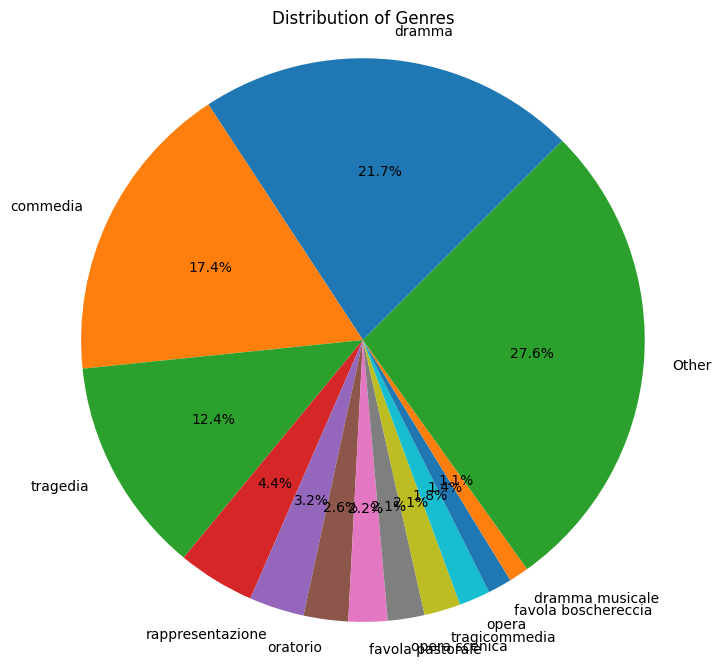

In [ ]:
# prompt: piechart from the column df[genere/genre], everything under 5% goes into an "other" slice

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'genere/genre' is the column name.
# Replace 'genere/genre' with the actual column name if it's different.

def plot_genre_piechart(df, column_name='genere/genre'):
    genre_counts = df[column_name].value_counts()
    total_count = genre_counts.sum()

    # Calculate percentages and identify genres below the 5% threshold
    percentages = genre_counts / total_count * 100
    other_genres = percentages[percentages < 1].index
    other_count = genre_counts[other_genres].sum()

    # Create the pie chart data with the 'Other' category
    pie_chart_data = percentages[percentages >= 1]
    if other_count > 0:
        pie_chart_data['Other'] = other_count / total_count * 100

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(pie_chart_data, labels=pie_chart_data.index, autopct='%1.1f%%', startangle=45)
    plt.title('Distribution of Genres')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


plot_genre_piechart(df)

In [ ]:
# prompt: print top most frequent items from the column "editore/publisher" of df, and next to them, the count of all the autori/authors in the same row, don't count the same author twice

import pandas as pd

# Assuming 'df' is your DataFrame loaded from the JSON file as shown in your code.
# If not, load your DataFrame here first.

def top_frequent_publishers_with_author_counts(df, top_n=10):
    """
    Prints the top N most frequent publishers and the count of unique authors associated with them.
    """
    publisher_counts = df.groupby("editore/publisher")["autore/author"].nunique().sort_values(ascending=False)

    for publisher, author_count in publisher_counts.head(top_n).items():
        print(f"{publisher}: {author_count}")

# Example usage:
top_frequent_publishers_with_author_counts(df, top_n=10) # prints the top 10 publishers and unique authors


unknown: 374
<a href="https://www.wikidata.org/wiki/Q98645100">Giuseppe Longhi</a>: 89
<a href="https://www.wikidata.org/wiki/Q122599209">Marino Rossetti</a>: 73
Francesco Niccolini: 61
<a href=\"https://www.wikidata.org/wiki/Q24238356\">unknown</a>: 36
<a href="https://www.wikidata.org/wiki/Q93123102">Giacomo Monti</a>: 28
Carlo Buonarrigo: 26
<a href="https://www.wikidata.org/wiki/Q19569565">Domenico Lovisa</a>: 26
<a href="https://www.wikidata.org/wiki/Q3107961">Giunti</a>: 26
<a href="https://www.wikidata.org/wiki/Q17279972">Giovanni Battista Ciotti</a>: 24


In [ ]:
count_entries = ((df['anno/year'] >= 1561) & (df['anno/year'] <= 1710)).sum()
print("Number of texts between 1561 and 1710:", count_entries)

Number of texts between 1561 and 1710: 3817


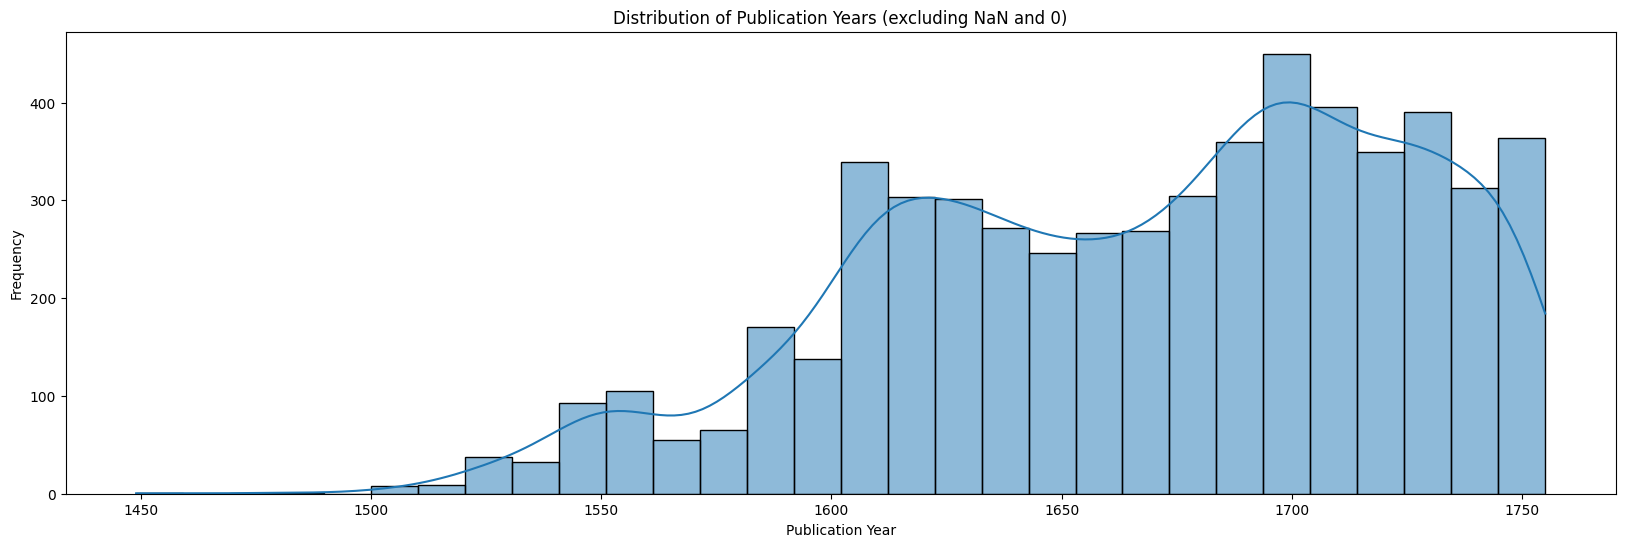

In [ ]:
# prompt: histogram based on df["anno/year"]. ignore all items where anno/year is nan or 0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is named 'df' and has already been loaded.
# If not, load it here using pd.read_csv('your_file.csv') or pd.read_json('your_file.json').


# Filter out NaN and 0 values in 'anno/year' column
filtered_df = df[(df['anno/year'].notna()) & (df['anno/year'] != 0)]

# Create the histogram
plt.figure(figsize=(20, 6))  # Adjust figure size as needed
sns.histplot(filtered_df['anno/year'], kde=True) # Use seaborn's histplot with KDE for smoother distribution visualization
plt.title('Distribution of Publication Years (excluding NaN and 0)')
plt.xlabel('Publication Year')
plt.ylabel('Frequency')
plt.show()

<ipython-input-67-144a5ff33e1f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



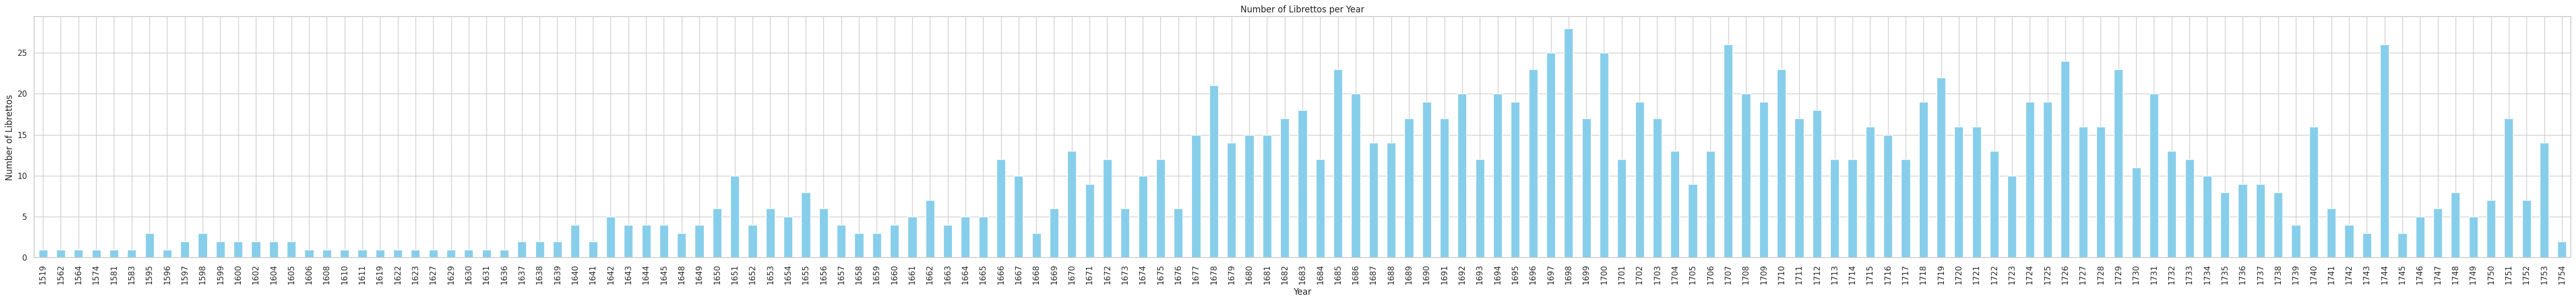

In [ ]:
# Filter out invalid years, format in boolean, filter out non-libretti
filtered_df = df[(df['anno/year'].notna()) & (df['anno/year'] != 0)]
filtered_df['libretto'] = filtered_df['libretto'].apply(lambda x: str(x).lower() == 'true')
libretto_df = filtered_df[filtered_df['libretto']]

# Check if the resulting DataFrame is empty
if libretto_df.empty:
    print("No data available after filtering. Please check the 'anno/year' and 'libretto' columns.")
else:
    # Group by year and count the number of librettos
    libretto_counts = libretto_df.groupby('anno/year')['libretto'].count()

    # Plot the histogram
    plt.figure(figsize=(50, 6))
    libretto_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Librettos per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Librettos')
    plt.tight_layout()
    plt.show()


In [ ]:
# Load the dataframe
df1 = pd.read_csv("query(1).csv")

# Split the 'geo' column into two separate columns 'lon' and 'lat'
df1[['lon', 'lat']] = df1['geo'].str.extract(r'Point\(([-\d.]+)\s+([-\d.]+)\)')

# Convert lat and lon to float type
df1['lon'] = df1['lon'].astype(float)
df1['lat'] = df1['lat'].astype(float)

# Display the result
print(df1)


                                 geo       label        lon        lat
0         Point(10.885 44.783333333)       Carpi  10.885000  44.783333
1   Point(10.654166666 44.921388888)   Guastalla  10.654167  44.921389
2   Point(10.654166666 44.921388888)   Guastalla  10.654167  44.921389
3   Point(12.783333333 41.666666666)    Velletri  12.783333  41.666667
4              Point(12.183333 42.1)   Bracciano  12.183333  42.100000
..                               ...         ...        ...        ...
90  Point(12.296944444 45.887222222)  Conegliano  12.296944  45.887222
91  Point(11.714722222 44.353055555)       Imola  11.714722  44.353056
92  Point(11.988055555 43.275555555)     Cortona  11.988056  43.275556
93  Point(11.883333333 44.285555555)      Faenza  11.883333  44.285556
94      Point(13.552530555 43.39855)    Recanati  13.552531  43.398550

[95 rows x 4 columns]


In [ ]:
top_locations = df['luogo di pubblicazione/city'].value_counts()
top_locations

luogo di pubblicazione/city
<a href="https://www.wikidata.org/wiki/Q641">Venice</a>              1927
<a href="https://www.wikidata.org/wiki/Q1891">Bologna</a>             518
<a href="https://www.wikidata.org/wiki/Q2044">Florence</a>            394
<a href="https://www.wikidata.org/wiki/Q220">Rome</a>                 369
<a href="https://www.wikidata.org/wiki/Q2634">Naples</a>              367
                                                                     ... 
<a href="https://www.wikidata.org/wiki/Q17686">Tortona</a>              1
<a href="https://www.wikidata.org/wiki/Q20103">Assisi</a>               1
<a href="https://www.wikidata.org/wiki/Q20579">Todi</a>                 1
<a href="https://www.wikidata.org/wiki/Q160262">Caprarola</a>           1
<a href="https://www.wikidata.org/wiki/Q239">City of Brussels</a>       1
Name: count, Length: 135, dtype: int64

In [ ]:
import pandas as pd
import folium
import requests
import time
import re


# Extract counts with only the Wikidata IDs
url_counts = df['luogo di pubblicazione/city'].value_counts().to_dict()

# Regular expression to extract the Wikidata ID (e.g., Q40996)
id_counts = {}
for html, count in url_counts.items():
    match = re.search(r'/wiki/(Q\d+)', html)  # Finds 'Q' followed by digits
    if match:
        wikidata_id = match.group(1)
        id_counts[wikidata_id] = count

# Proceed with the cleaned `id_counts` dictionary
unique_ids = list(id_counts.keys())

# Function to fetch coordinates for a batch of Wikidata IDs
def fetch_coordinates(batch):
    # Construct SPARQL query for the batch
    sparql_query = """
    SELECT ?place ?lat ?lon WHERE {
      VALUES ?place {""" + " ".join(f"wd:{qid}" for qid in batch) + """}
      ?place wdt:P625 ?coord.
      ?coord wikibase:latitude ?lat;
             wikibase:longitude ?lon.
    }
    """

    # Send the request to the Wikidata SPARQL endpoint
    sparql_url = "https://query.wikidata.org/sparql"
    headers = {"Accept": "application/sparql-results+json"}
    try:
        response = requests.get(sparql_url, params={'query': sparql_query}, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error for 4xx or 5xx HTTP codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None

# Fetch data in batches and compile results
coordinates = {}
batch_size = 50  # Define the batch size
for i in range(0, len(unique_ids), batch_size):
    batch = unique_ids[i:i + batch_size]
    data = fetch_coordinates(batch)
    if data:
        for item in data['results']['bindings']:
            qid = item['place']['value'].split('/')[-1]
            lat = float(item['lat']['value'])
            lon = float(item['lon']['value'])
            count = id_counts.get(qid, 1)
            coordinates[qid] = ((lat, lon), count)
    time.sleep(1)  # Pause to avoid rate limiting

# Plot results on a map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers with size based on count
for qid, ((lat, lon), count) in coordinates.items():
    folium.CircleMarker(
        location=[lat, lon],
        radius=5 + count * 0.5,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{qid} (count: {count})"
    ).add_to(m)

# Save and display map
m.save("map_with_counts.html")
m  # For Jupyter notebooks


In [ ]:
def visualise(info, plot_type):
    filtered_df = df[df[info].notna() & (df[info] != "Unknown")]

    # Get the top 15 entries sorted by frequency
    top_15_values = filtered_df[info].value_counts().head(15)

    # Print the top 15 values and their frequencies
    for value, frequency in top_15_values.items():
        print(f"{value}: {frequency}")

    # Create a DataFrame for the top 15 values
    top_15_df = filtered_df[filtered_df[info].isin(top_15_values.index)]

    # Sort values by frequency in descending order
    sorted_values = top_15_df[info].value_counts().index

    # Dynamically call the specified plot method
    getattr(plt, plot_type)(sorted_values, top_15_df[info].value_counts(),
                            color='darkred', edgecolor='black')

    plt.xlabel(f"{info}")
    plt.ylabel('frequency')

    # Set x-axis ticks and labels based on sorted order of frequencies
    plt.xticks(sorted_values, [f'{value}' for value in sorted_values], rotation=90, ha="right")

    plt.show()

In [ ]:
visualise('autore/author',plot_type="barh")

In [ ]:
# plot locations

data = {'Venezia': 1814, 'Bologna': 517, 'Roma': 359, 'Napoli': 358, 'Firenze': 351,
        'Vienna': 241, 'Palermo': 208, 'Siena': 195, 'Milano': 159, 'Ferrara': 91,
        'Viterbo': 90, 'Padova': 87, 'Verona': 74, 'Mantova': 56, 'Vicenza': 55,
        'Macerata': 52, 'Parma': 49, 'Modena': 46, 'Ronciglione': 40, 'Genova': 38,
        'Lucca': 34, 'Perugia': 32, 'Brescia': 31, 'Torino': 30, 'Lipsia': 30}

# Simplified dataset of city coordinates (latitude, longitude)
city_coordinates = {
      'Venezia': (45.4408474, 12.3155151),
      'Bologna': (44.494887, 11.342616),
      'Roma': (41.9027835, 12.4963655),
      'Napoli': (40.852162, 14.2681103),
      'Firenze': (43.7695604, 11.2558136),
      'Vienna': (48.2083537, 16.3725042),
      'Palermo': (38.1157, 13.3615),
      'Siena': (43.3186, 11.3307),
      'Milano': (45.4642, 9.1900),
      'Ferrara': (44.8350, 11.6180),
      'Viterbo': (42.4174, 12.1047),
      'Padova': (45.4064, 11.8768),
      'Verona': (45.4384, 10.9916),
      'Mantova': (45.1569, 10.7910),
      'Vicenza': (45.5455, 11.5350),
      'Macerata': (43.3000, 13.4532),
      'Parma': (44.8015, 10.3279),
      'Modena': (44.6471, 10.9252),
      'Ronciglione': (42.2711, 12.1987),
      'Genova': (44.4056, 8.9463),
      'Lucca': (43.8420, 10.5027),
      'Perugia': (43.1107, 12.3890),
      'Brescia': (45.5416, 10.2118),
      'Torino': (45.0703, 7.6869),
      'Lipsia': (51.3432, 12.3809)
}

# Create a map centered around Italy
m = folium.Map(location=[41.8719, 12.5674], zoom_start=4)

# Add markers for each city with the size proportional to the number of events
for city, events in data.items():
    coordinates = city_coordinates.get(city)
    if coordinates:
        folium.CircleMarker(
            location=coordinates,
            radius=events / 50,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.2,
            popup=f"{city}: {events} events"
        ).add_to(m)

# Display the map in Colab
m

In [ ]:
# print the corpus' diachronic span

filtered_df = df[df['year'].notna() & (df['year'] != "Unknown")]

# Plot histogram
plt.hist(filtered_df['year'], bins=range(1500, 1760, 10), color="darkgreen", edgecolor='black')

# Set major labels every 50 years
major_labels = range(1500, 1760, 10)
plt.xticks(major_labels, rotation=90)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('No. of works')

# Show the plot
plt.show()

Let's explore correlation of authors and printers

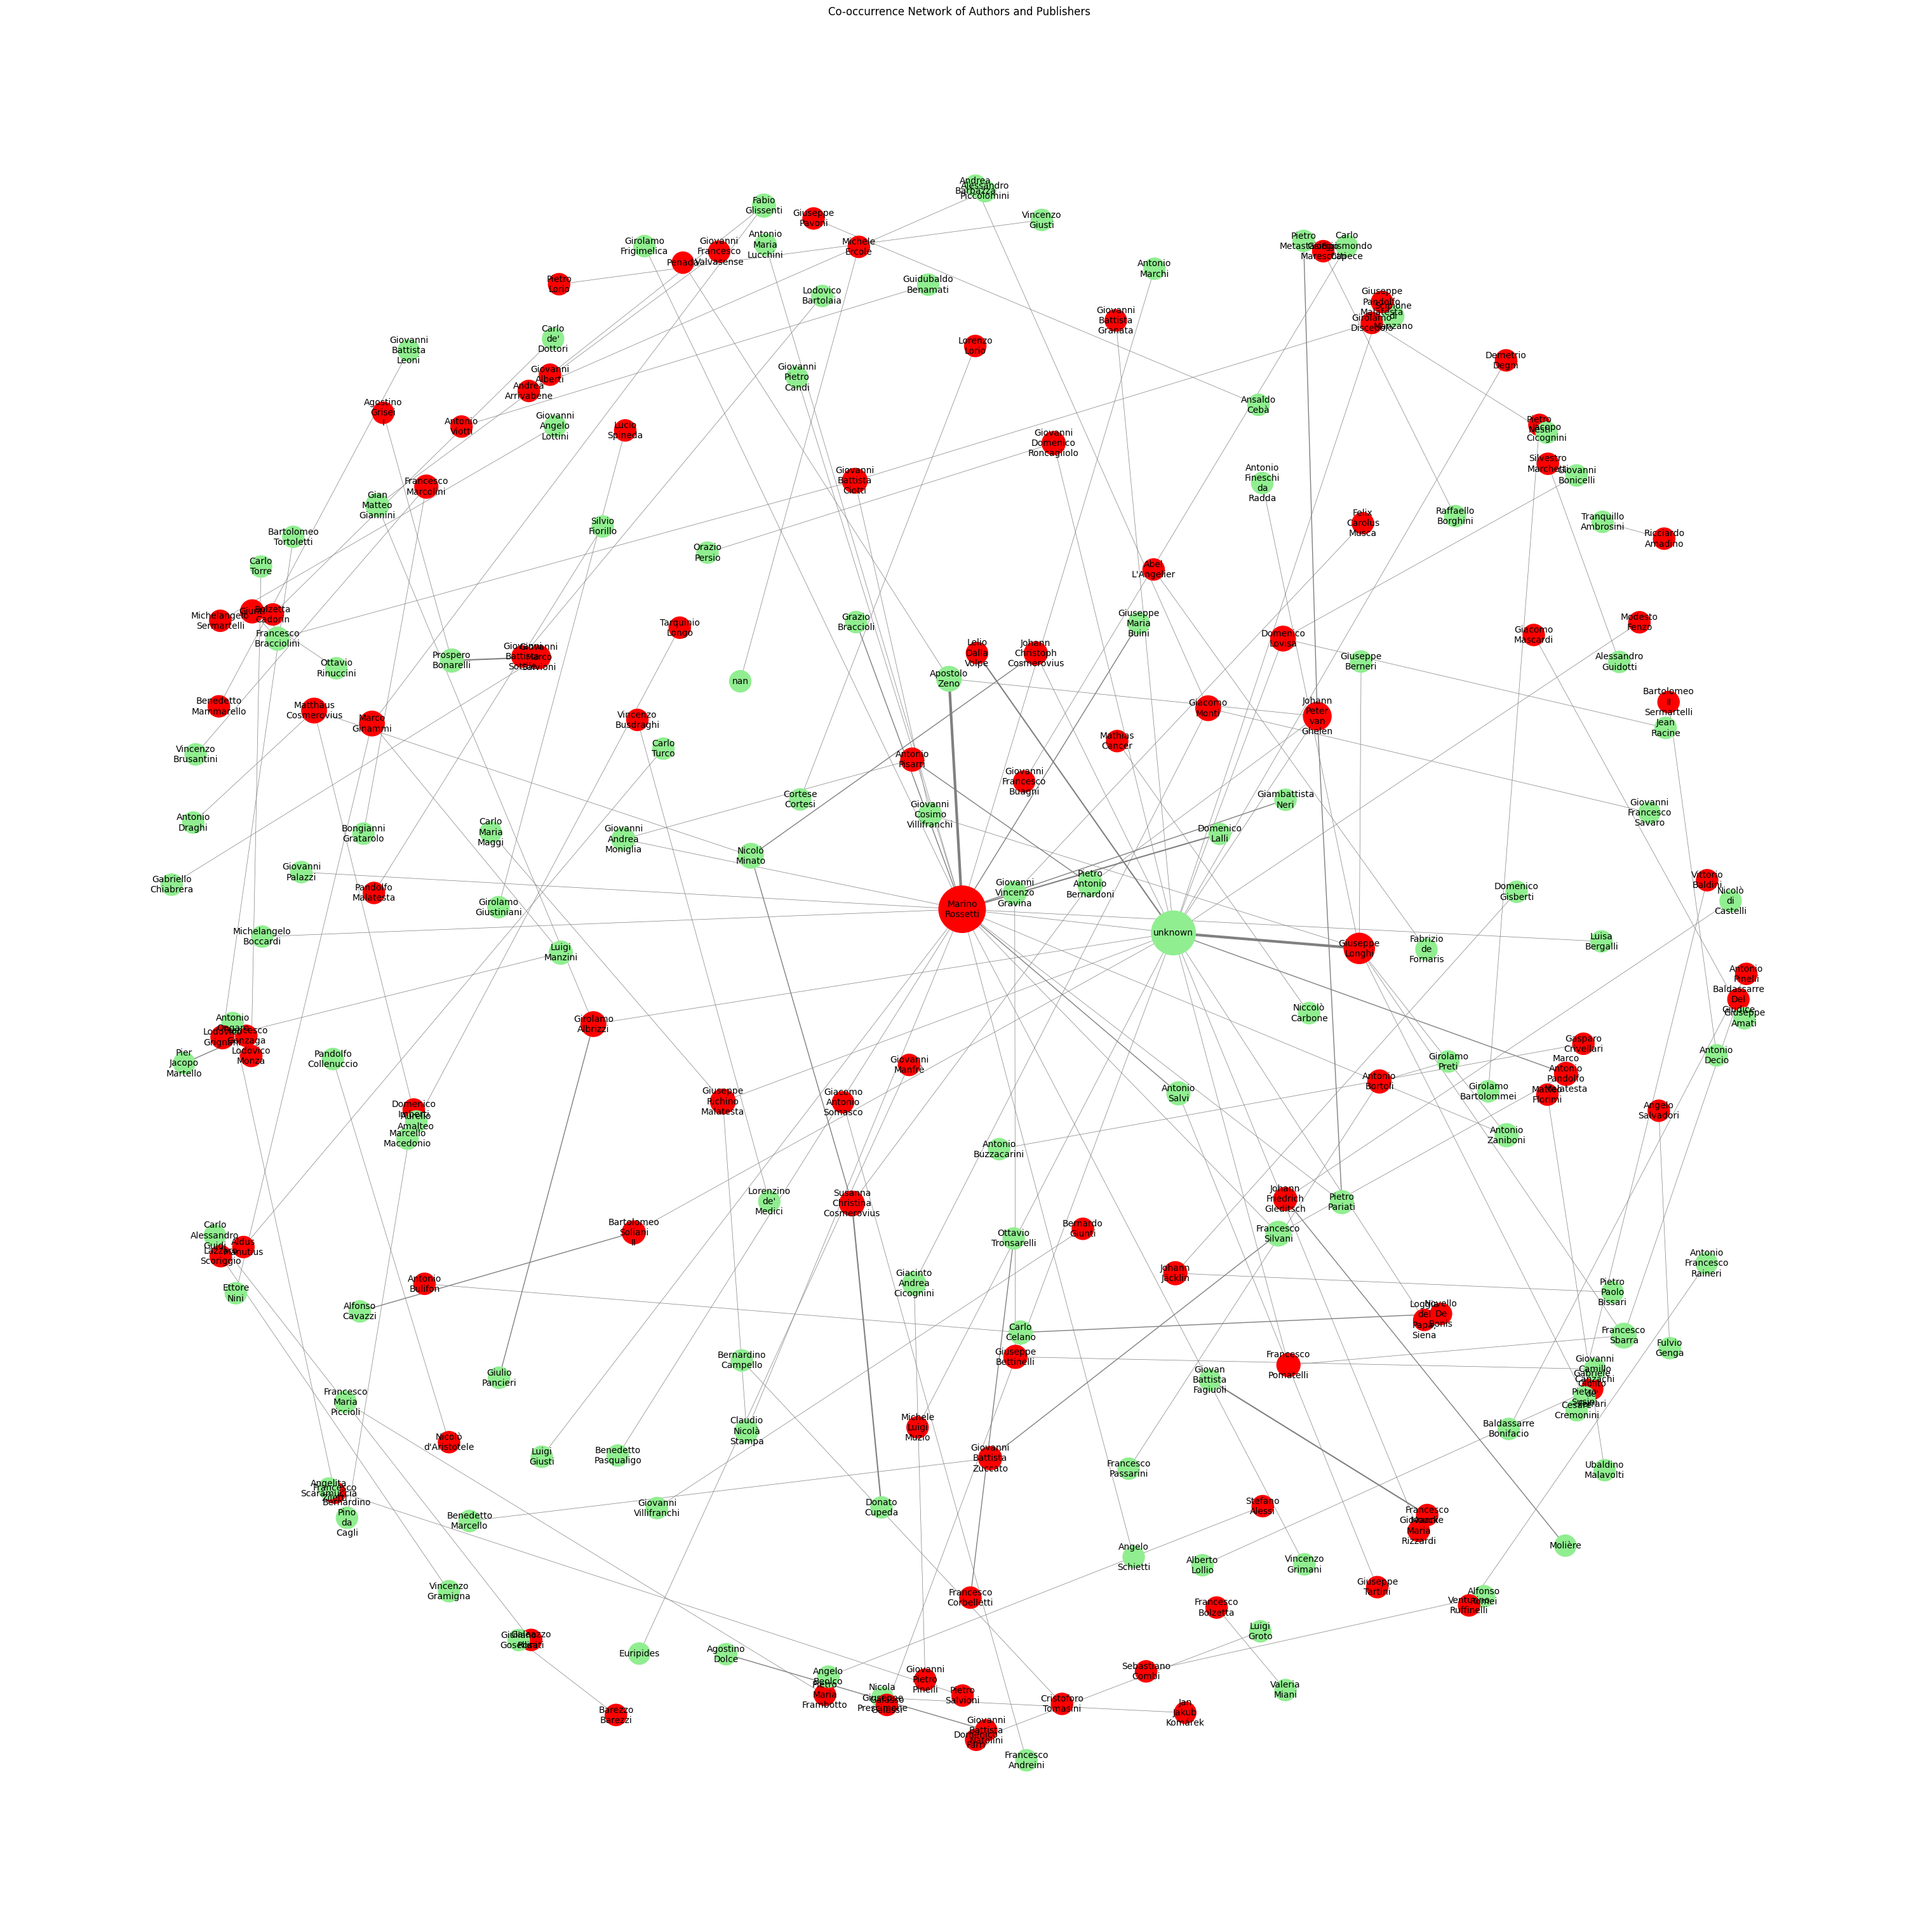

In [ ]:
# Function to extract text from HTML anchor tags
new_df = df.copy()

# Function to extract text from HTML anchor tags
def extract_html_text(text):
    if isinstance(text, str) and '<a href=' in text:
        match = re.search(r'<a href="[^"]*">(.*?)</a>', text)
        if match:
            return match.group(1)  # Extract the text between the tags
    return None  # Return None if not wrapped in HTML

# Apply the function to the columns
new_df['autore/author'] = new_df['autore/author'].apply(extract_html_text)
new_df['editore/publisher'] = new_df['editore/publisher'].apply(extract_html_text)

# Filter out rows where either author or publisher is None
new_df = new_df[new_df['autore/author'].notnull() & new_df['editore/publisher'].notnull()]

# Build the co-occurrence network
graph = nx.Graph()

# Add edges and nodes to the graph with appropriate colors
for index, row in new_df.head(200).iterrows():
    author = row['autore/author']
    publisher = row['editore/publisher']
    graph.add_node(author, type='author')  # Add author node
    graph.add_node(publisher, type='publisher')  # Add publisher node
    graph.add_edge(author, publisher, weight=graph[author][publisher]['weight'] + 1 if graph.has_edge(author, publisher) else 1)

# Visualize the network
pos = nx.spring_layout(graph, k=0.5)  # Use a layout to minimize overlap

# Prepare node colors based on type
node_colors = ['lightgreen' if graph.nodes[node]['type'] == 'author' else 'red' for node in graph.nodes()]

# Calculate node sizes based on degree
node_sizes = [500 + graph.degree(node) * 100 for node in graph.nodes()]  # Scale sizes

# Edge widths based on weights
edge_widths = [data['weight'] * 0.5 for _, _, data in graph.edges(data=True)]

# Prepare labels with line breaks
labels = {node: node.replace(' ', '\n') for node in graph.nodes()}

# Draw the graph
plt.figure(figsize=(30, 30))

# Draw nodes and edges
nx.draw(graph, pos, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=edge_widths)

# Manually position labels to reduce overlap
for node in graph.nodes():
    x, y = pos[node]
    plt.text(x, y, labels[node], fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='none', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

plt.title('Co-occurrence Network of Authors and Publishers')
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Create a new DataFrame with the desired format
authors = new_df['autore/author'].apply(lambda x: (x, 'author'))
publishers = new_df['editore/publisher'].apply(lambda x: (x, 'publisher'))

# Combine authors and publishers into a single DataFrame
combined = pd.DataFrame(authors.tolist(), columns=['Name', 'Label'])
combined = pd.concat([combined, pd.DataFrame(publishers.tolist(), columns=['Name', 'Label'])], ignore_index=True)

# Save the combined DataFrame as a CSV file
combined.to_csv('authors_publishers.csv', index=False)

## EDA of titles


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import re
import requests

In [ ]:
import spacy
!python -m spacy download it_core_news_sm
!python -m spacy download it_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 19.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install stanza
import stanza
stanza.download('it')
nlp = stanza.Pipeline('it')
import requests
!pip install gender-guesser
import gender_guesser.detector as gender

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 22.4 MB/s eta 0:00:00


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: it (Italian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/it/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: it (Italian):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | vit_charlm        |
| depparse     | combined_charlm   |
| ner          | fbk               |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
# get Italian words and names
url = "https://gist.githubusercontent.com/allanlewis/ddfe6e7053fd12986589c52edf6ef856/raw/bc6ca7a55527930ec5f25e448c3aa0a7deee2de6/italian-first-names.txt"
response = requests.get(url).text
italian_names = response.split('\n')
italian_names = [name.lower() for name in italian_names]

url2 = "https://raw.githubusercontent.com/napolux/paroleitaliane/refs/heads/master/paroleitaliane/60000_parole_italiane.txt"
response = requests.get(url2).text
italian_words = response.split('\n')
#italian_words

In [ ]:
# load df from github

url = 'https://raw.githubusercontent.com/allacci-digitale/allacci-digitale.github.io/main/data/database.json'
df = pd.read_json(url)
df.head(1)

voce/entry    titolo/title  \
0  ABBAGLI FELICI. Commedia (in prosa). — In Mace...  Abbagli Felici   

  sottotitolo/subtitle                                      autore/author  \
0                       <a href="https://www.wikidata.org/wiki/Q340782...   

  genere/genre metro/mode                        luogo di pubblicazione/city  \
0     commedia      prose  <a href="https://www.wikidata.org/wiki/Q13135"...   

  luogo di rappresentazione/location  \
0                                      

                                   editore/publisher  anno/year  \
0  <a href="https://www.wikidata.org/wiki/Q118733...       1642   

  formato/format libretto compositore/composer traduzione/translation  
0             12    False                                       False

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"d\'", " ", text)  # Remove 'd' '
    #text = re.sub(r'\(', '', text)  # Remove '('
    text = re.sub(r',', '', text)  # Remove commas
    text = text.strip()
    # Remove Italian stop words
    italian_stop_words = set(stopwords.words('italian'))
    italian_stop_words.add("de'")
    tokens = [word for word in text.split() if word not in italian_stop_words]
    tokens = [re.sub(r"\'", ' ', token) for token in tokens]
    tokens = [re.sub(r"\(", '', token) for token in tokens]
    tokens = [re.sub(r"\)", '', token) for token in tokens]
    # Remove Italian person names -- were waiting to find a better solution
    #tokens = [word for word in tokens if word not in italian_names and word != 'de\'']

    return ' '.join(tokens)

In [ ]:
# Apply the preprocessing function to the 'titolo/title' column
df['processed_title'] = df['titolo/title'].apply(preprocess_text)

# Create a list of preprocessed titles
processed_titles = df['processed_title'].tolist()

# Create a dictionary to store word counts
word_counts = {}
for title in processed_titles:
    for word in title.split():
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1

# Sort the word counts in descending order
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Print the top 20 most frequent words
for word, count in list(sorted_word_counts.items())[:100]:
    print(f"{word}: {count}")


amore: 204
santa: 125
amor: 113
san: 97
re: 86
dell: 85
vergine: 68
trionfante: 67
cristo: 65
trionfo: 64
martirio: 60
amante: 48
forza: 48
costanza: 47
l: 46
due: 45
innocenza: 44
amori: 43
regina: 42
fede: 42
fortuna: 41
gesù: 41
martire: 40
morte: 37
sant: 35
maria: 33
amanti: 31
virtù: 31
costante: 29
inganno: 29
alessandro: 28
finto: 28
ercole: 27
inganni: 27
conversione: 26
principe: 25
amorosa: 25
caterina: 25
nozze: 24
armida: 23
vittoria: 23
maddalena: 23
amorosi: 22
gran: 22
vendetta: 22
pazzia: 22
santi: 22
cesare: 22
mondo: 21
tiranno: 20
vita: 20
finta: 20
tre: 20
rivali: 19
amicizia: 19
ninfa: 19
commedia: 19
tradimento: 19
cecilia: 18
nell: 18
onore: 18
pace: 18
natale: 18
donne: 18
gelosia: 17
geloso: 17
davide: 17
moglie: 17
ester: 17
giovanni: 17
ifigenia: 17
pastor: 17
principessa: 16
fedele: 16
donna: 16
notte: 16
ulisse: 16
ciro: 16
edipo: 16
enea: 16
scipione: 16
giuditta: 16
agata: 15
delusa: 15
fortunato: 15
vuol: 15
passione: 15
apollo: 15
paride: 15
gloria: 15

In [ ]:
genre_counts = df['genere/genre'].value_counts()
pd.set_option('display.max_rows', None)
print(genre_counts)

genere/genre
dramma                               1321
commedia                             1056
tragedia                              754
                                      269
rappresentazione                      192
oratorio                              155
favola pastorale                      136
opera scenica                         128
tragicommedia                         127
opera                                 108
favola boschereccia                    84
dramma musicale                        69
tragedia sacra                         60
azione sacra                           56
dialogo                                55
rappresentazione sacra                 52
intermezzi                             45
componimento                           41
melodramma                             41
serenata                               41
opera tragica                          30
tragicommedia pastorale                28
opera tragicomica                      24
rappresentazione spir

#### Evolution of the length of titles (in characters)

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming your dataframe is named 'df'
# and it has columns 'titolo/title' and 'anno/year'

# Remove rows with None or NaN values in the 'anno/year' column
df = df.dropna(subset=['anno/year'])
df = df[df['anno/year'] != 0]

# Calculate the length of each title
df['title_length'] = df['titolo/title'].astype(str).str.len()

# Create the scatter plot
fig = px.scatter(
    df,
    x='anno/year',
    y='title_length',
    hover_data={'titolo/title': True, 'title_length': False},
    labels={'anno/year': 'Year', 'title_length': 'Title Length (characters)', 'titolo/title': 'Title'},
    title='Title Length over Time',
    trendline="lowess"
)

for trace in fig.data:
    if trace.mode == 'lines':  # Identify the trendline trace
        trace.line.color = 'red'  # Change to desired color (e.g., 'red')

# Customize the layout
fig.update_traces(marker=dict(size=6))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Title Length (characters)',
    template='plotly_white'
)

fig.show()

#### Evolution of the length of titles (in words)

In [ ]:
# Create a list of preprocessed titles
processed_titles = df['processed_title'].tolist()

# Create a dictionary to store word counts
word_counts = {}
for title in processed_titles:
    word_count = len(title.split())
    if word_count not in word_counts:
        word_counts[word_count] = 0
    word_counts[word_count] += 1


sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Print the ranking
for word_count, count in sorted_word_counts.items():
  print(f"Titles with {word_count} words: {count} times")



Titles with 2 words: 2312 times
Titles with 1 words: 2190 times
Titles with 3 words: 625 times
Titles with 4 words: 247 times
Titles with 5 words: 113 times
Titles with 6 words: 63 times
Titles with 7 words: 30 times
Titles with 8 words: 27 times
Titles with 9 words: 8 times
Titles with 10 words: 7 times
Titles with 11 words: 5 times
Titles with 12 words: 4 times
Titles with 0 words: 1 times
Titles with 13 words: 1 times
Titles with 17 words: 1 times
Titles with 27 words: 1 times
Titles with 16 words: 1 times
Titles with 15 words: 1 times
Titles with 19 words: 1 times
Titles with 14 words: 1 times


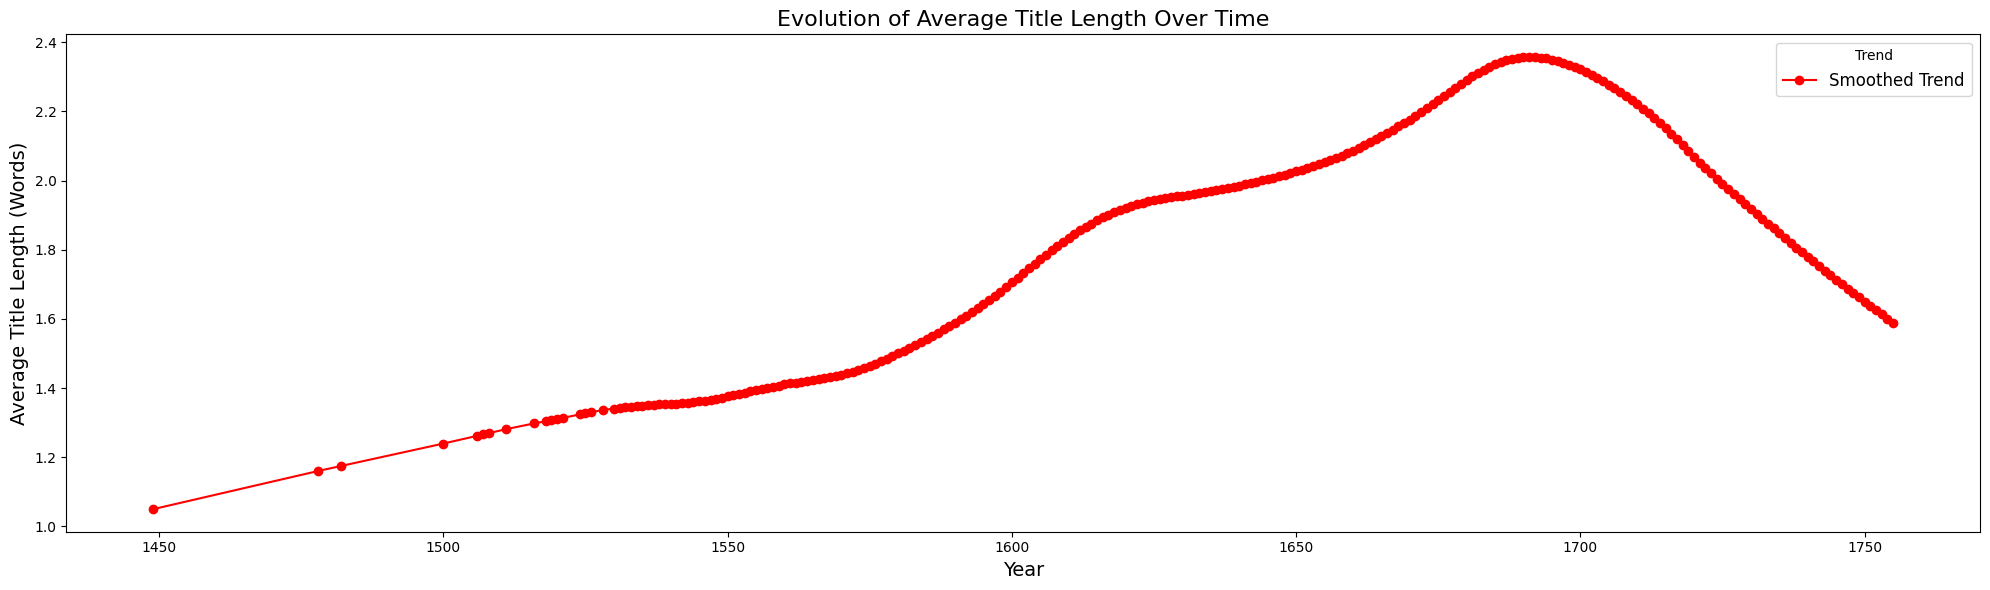

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'test_df' is your DataFrame and it has columns 'processed_title' and 'anno/year'
test_df = df.copy()

# Sorting the dataframe by year to ensure a proper time series plot
test_df = test_df[test_df['anno/year'] != 0]

# Calculate title length in words (by splitting the title by spaces)
test_df['title_length'] = test_df['processed_title'].apply(lambda x: len(x.split()))

# Group the data by 'anno/year' and calculate the average title length for each year
avg_title_length = test_df.groupby('anno/year')['title_length'].mean().reset_index()

# Set the plot size for better readability
plt.figure(figsize=(20, 6))

# Apply lowess smoothing and plot the overall trend
smoothed_title_length = sm.nonparametric.lowess(avg_title_length['title_length'], avg_title_length['anno/year'], frac=0.3)

# Plot the trendline
plt.plot(smoothed_title_length[:, 0], smoothed_title_length[:, 1], label='Smoothed Trend', marker='o', color='red')

# Add titles and labels
plt.title('Evolution of Average Title Length Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Title Length (Words)', fontsize=14)

# Show legend
plt.legend(title="Trend", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



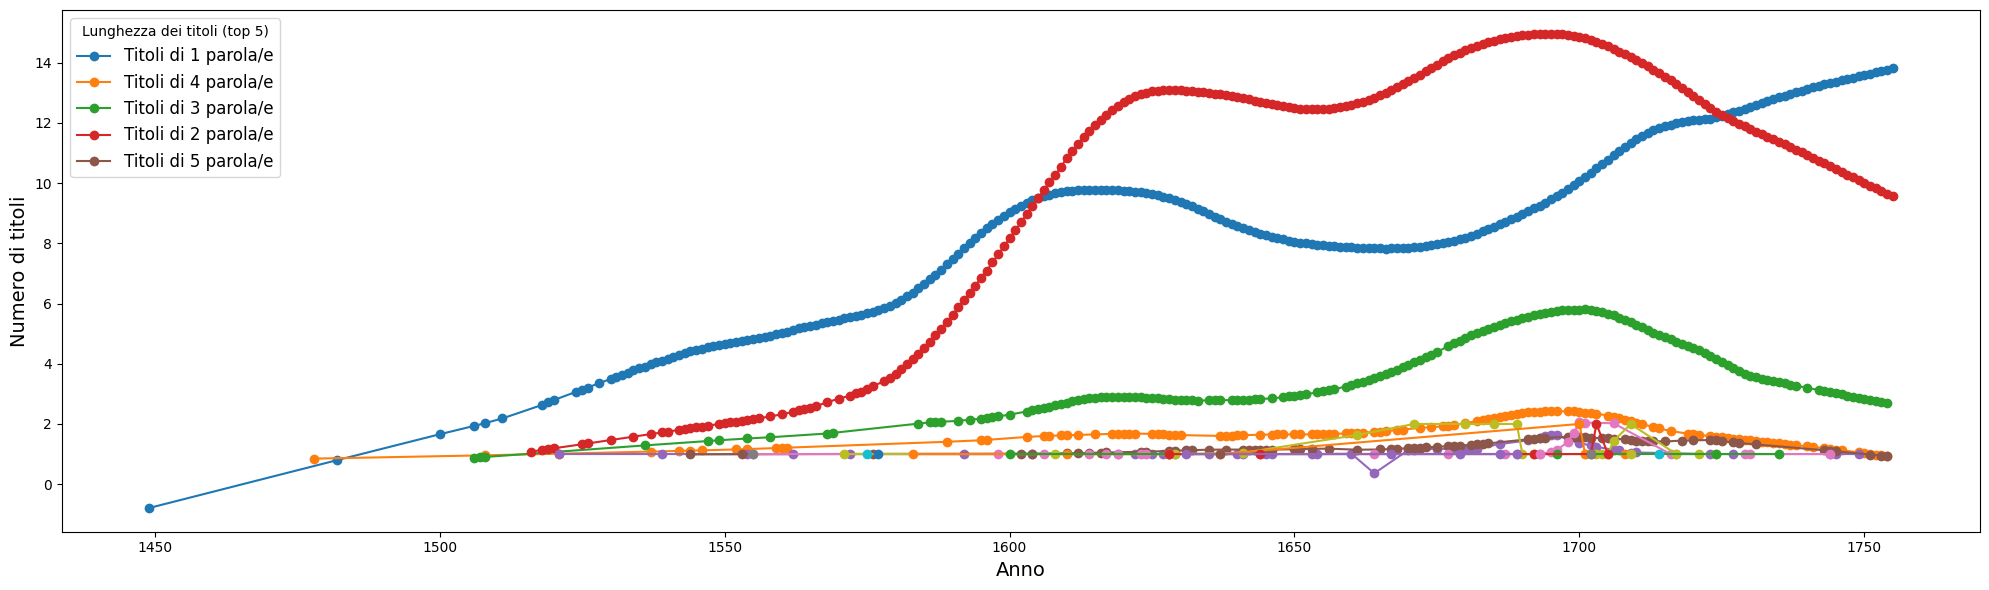

In [ ]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Sorting the dataframe by year to ensure a proper time series plot
# df = test_df['anno/year'] != 0

# Calculate title length in words (by splitting the title by spaces)
df['title_length'] = df['processed_title'].apply(lambda x: len(x.split()))

# Group the data by 'anno/year' and 'title_length', then count the number of titles for each combination
title_counts = df.groupby(['anno/year', 'title_length']).size().reset_index(name='count')

# Identify the 5 most frequent title lengths
top_title_lengths = title_counts.groupby('title_length')['count'].sum().nlargest(5).index

# Set the plot size for better readability
plt.figure(figsize=(20, 6))

# Apply lowess smoothing and plot for each title length
handles = []
for title_len in title_counts['title_length'].unique():
    subset = title_counts[title_counts['title_length'] == title_len]

    # Apply lowess smoothing
    smoothed = sm.nonparametric.lowess(subset['count'], subset['anno/year'], frac=0.3)

    # Plot the smoothed line with markers
    line, = plt.plot(smoothed[:, 0], smoothed[:, 1], label=f'Titoli di {title_len} parola/e', marker='o')
    # Collect handles only for top 5 labels
    if title_len in top_title_lengths:
        handles.append(line)

# Add titles and labels
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Numero di titoli', fontsize=14)

# Add the modified legend with only the top 5 labels
plt.legend(handles=handles, title="Lunghezza dei titoli (top 5)", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


Is there a correlation between genre and title length?

In [ ]:
test_df['title_length'] = test_df['processed_title'].apply(lambda x: len(x.split()))
# Average title length by genre
title_length_by_genre = test_df.groupby('genere/genre')['title_length'].mean().sort_values()

print("\nAverage title length by genre:")
title_length_by_genre
"""
# Temporal patterns in title lengths and genres
test_df['decade'] = (test_df['anno/year'] // 10 + 1) * 10  # Extract the decade

# Share of n-word titles by century and genre
n = input("No. of words in title to explore:",)
test_df['is_n_words'] = test_df['title_length'] == n

# Aggregation: Share of 2-word titles per genre and century
share_n_words = test_df.groupby(['decade', 'genere/genre'])['is_n_words'].mean().reset_index()

print(f"\nShare of {n}-word titles by century and decade:")
print(share_n_words)
"""

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for "commedia", "tragedia", and "dramma" genres
commedia_df = df[(df['genere/genre'] == 'commedia') & (df['anno/year'].notna()) & (df['anno/year'] != 0)]
tragedia_df = df[(df['genere/genre'] == 'tragedia') & (df["anno/year"].notna()) & (df["anno/year"] != 0)]
dramma_df = df[(df['genere/genre'] == 'dramma') & (df['anno/year'].notna()) & (df['anno/year'] != 0)]

# Group by year and count occurrences
commedia_counts = commedia_df.groupby('anno/year').size().reset_index(name='counts')
tragedia_counts = tragedia_df.groupby('anno/year').size().reset_index(name='counts')
dramma_counts = dramma_df.groupby('anno/year').size().reset_index(name='counts')

# Apply a simple moving average (SMA) for smoothing
window_size = 5  # You can adjust the window size
commedia_counts['smoothed'] = commedia_counts['counts'].rolling(window=window_size, min_periods=1).mean()
tragedia_counts['smoothed'] = tragedia_counts['counts'].rolling(window=window_size, min_periods=1).mean()
dramma_counts['smoothed'] = dramma_counts['counts'].rolling(window=window_size, min_periods=1).mean()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(commedia_counts['anno/year'], commedia_counts['smoothed'], label='Commedia (Smoothed)', linewidth=2)
plt.plot(tragedia_counts['anno/year'], tragedia_counts['smoothed'], label='Tragedia (Smoothed)', linewidth=2)
plt.plot(dramma_counts['anno/year'], dramma_counts['smoothed'], label='Dramma (Smoothed)', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Number of Works')
plt.title('Evolution of Generic Labels Over Time (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

Let's visualise the most frequent words in titles

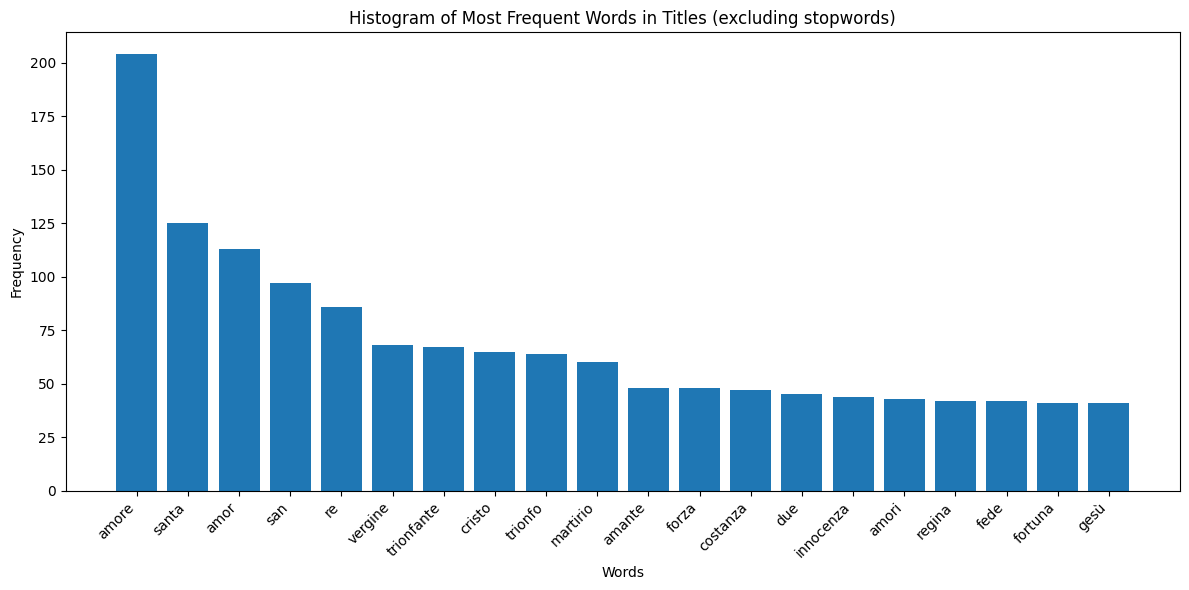

In [ ]:
# Assuming 'df' and 'processed_titles' are already defined as in the provided code

stop_words = ('dell','l')

# Create a dictionary to store word counts, skipping stopwords
word_counts = {}
for title in processed_titles:
    for word in title.split():
        if word not in stop_words:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1

# Sort the word counts in descending order
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Extract words and counts for the histogram
words = list(sorted_word_counts.keys())[:20]  # Take the top 20 words
counts = list(sorted_word_counts.values())[:20]

# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Histogram of Most Frequent Words in Titles (excluding stopwords)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
sorted_word_counts

In [ ]:
# Prepare the data
labels = list(sorted_word_counts.keys())  # Extract words
values = list(sorted_word_counts.values())  # Extract frequencies

# Ensure both lists are the same length
max_words = 40 #min(len(labels), len(values))  # Optional: Limit to 20 words if needed
labels = labels[:max_words]
values = values[:max_words]

# Create a DataFrame
data = pd.DataFrame({
    'labels': labels,
    'parents': [''] * max_words,  # Single-layer hierarchy
    'values': values
})

# Create the treemap
fig = px.treemap(data, path=['labels'], values='values', color='values',
                 color_continuous_scale='inferno')

# Show the treemap
fig.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


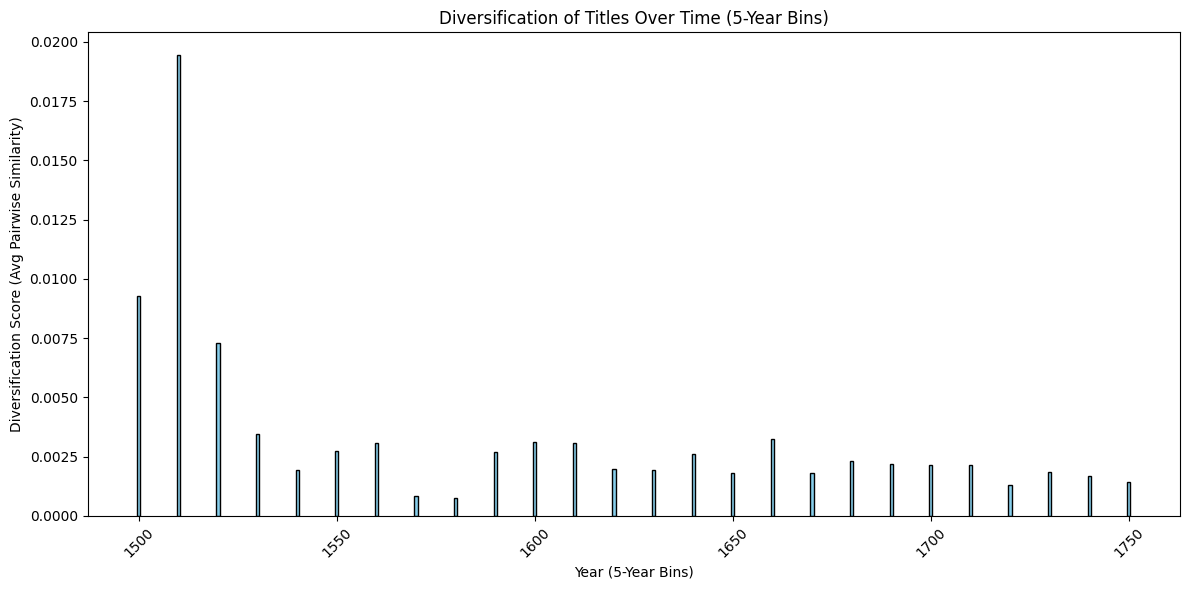

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Remove rows where 'anno/year' is NaN or 0
df = df[(df['anno/year'].notna()) & (df['anno/year'] != 0)]

# Convert tokenized titles back to string before applying TfidfVectorizer
df['tokenized_title'] = df['processed_title'].apply(word_tokenize)

# Create a function to calculate average pairwise cosine similarity
def avg_pairwise_similarity(titles):
    # Join the tokenized titles back into a string
    titles_as_strings = [" ".join(title) for title in titles]

    # Convert titles to TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(titles_as_strings)

    # Calculate pairwise cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix)

    # We want the average similarity of all pairs, excluding the diagonal
    num_titles = len(titles_as_strings)
    triu_indices = np.triu_indices(num_titles, k=1)
    avg_similarity = np.mean(cosine_sim[triu_indices])
    return avg_similarity

# Group by 5-year bins and calculate the average pairwise similarity
df['year_bin'] = (df['anno/year'] // 10) * 10  # Create 5-year bins

# Remove bins that correspond to years with no data (e.g., 0 or NaN values)
df = df[df['year_bin'] > 0]

diversification_scores = []

for year_bin in df['year_bin'].unique():
    titles_in_bin = df[df['year_bin'] == year_bin]['tokenized_title'].tolist()
    if len(titles_in_bin) > 1:  # Only calculate if there are more than 1 title
        diversification_scores.append((year_bin, avg_pairwise_similarity(titles_in_bin)))

# Convert the diversification scores into a DataFrame
diversification_df = pd.DataFrame(diversification_scores, columns=['Year Bin', 'Diversification Score'])

# Plot the bar chart of diversification scores
plt.figure(figsize=(12, 6))
plt.bar(diversification_df['Year Bin'], diversification_df['Diversification Score'], color='skyblue', edgecolor='black')
plt.title('Diversification of Titles Over Time (5-Year Bins)')
plt.xlabel('Year (5-Year Bins)')
plt.ylabel('Diversification Score (Avg Pairwise Similarity)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
entries_per_decade

In [ ]:
df.head()

voce/entry        titolo/title  \
0  ABBAGLI FELICI. Commedia (in prosa). — In Mace...      Abbagli Felici   
1  ABBANDONO D'ARMIDA. Trattenimento scenico cant...  Abbandono d'Armida   
2  ABBATE. Commedia (in prosa). — in Venez. appre...              Abbate   
3  ABBISAI. Op. (in prosa). — in Milano per il Ma...             Abbisai   
4  ABDOLOMINO. Dramma rappresentato alle Sac. Ces...          Abdolomino   

  sottotitolo/subtitle                                      autore/author  \
0                       <a href="https://www.wikidata.org/wiki/Q340782...   
1                                                        Giovanni Boldini   
2                                                    Bartolommeo Cappello   
3                                               Carlo Giuseppe Cornacchia   
4                       <a href="https://www.wikidata.org/wiki/Q137567...   

            genere/genre metro/mode  \
0               commedia      prose   
1  trattenimento scenico      verse   
2               commedia      prose   
3                  opera      prose   
4                 dramma              

                         luogo di pubblicazione/city  \
0  <a href="https://www.wikidata.org/wiki/Q13135"...   
1  <a href="https://www.wikidata.org/wiki/Q641">V...   
2  <a href="https://www.wikidata.org/wiki/Q641">V...   
3  <a href="https://www.wikidata.org/wiki/Q490">M...   
4  <a href="https://www.wikidata.org/wiki/Q1741">...   

                  luogo di rappresentazione/location  \
0                                                      
1  <a href="https://www.wikidata.org/wiki/Q398204...   
2                                                      
3                                                      
4                                                      

                                   editore/publisher  anno/year  \
0  <a href="https://www.wikidata.org/wiki/Q118733...       1642   
1                                   Carlo Buonarrigo       1729   
2  <a href="https://www.wikidata.org/wiki/Q109836...       1556   
3                                          Malatesta       1718   
4                                 Eredi Cosmeroviani       1709   

  formato/format libretto                               compositore/composer  \
0             12    False                                                      
1             12     True                                                      
2              8    False                                                      
3             12    False                                                      
4              8     True  <a href="https://www.wikidata.org/wiki/Q315241...   

  traduzione/translation   processed_title  
0                  False    abbagli felici  
1                  False  abbandono armida  
2                  False            abbate  
3                  False           abbisai  
4                  False        abdolomino

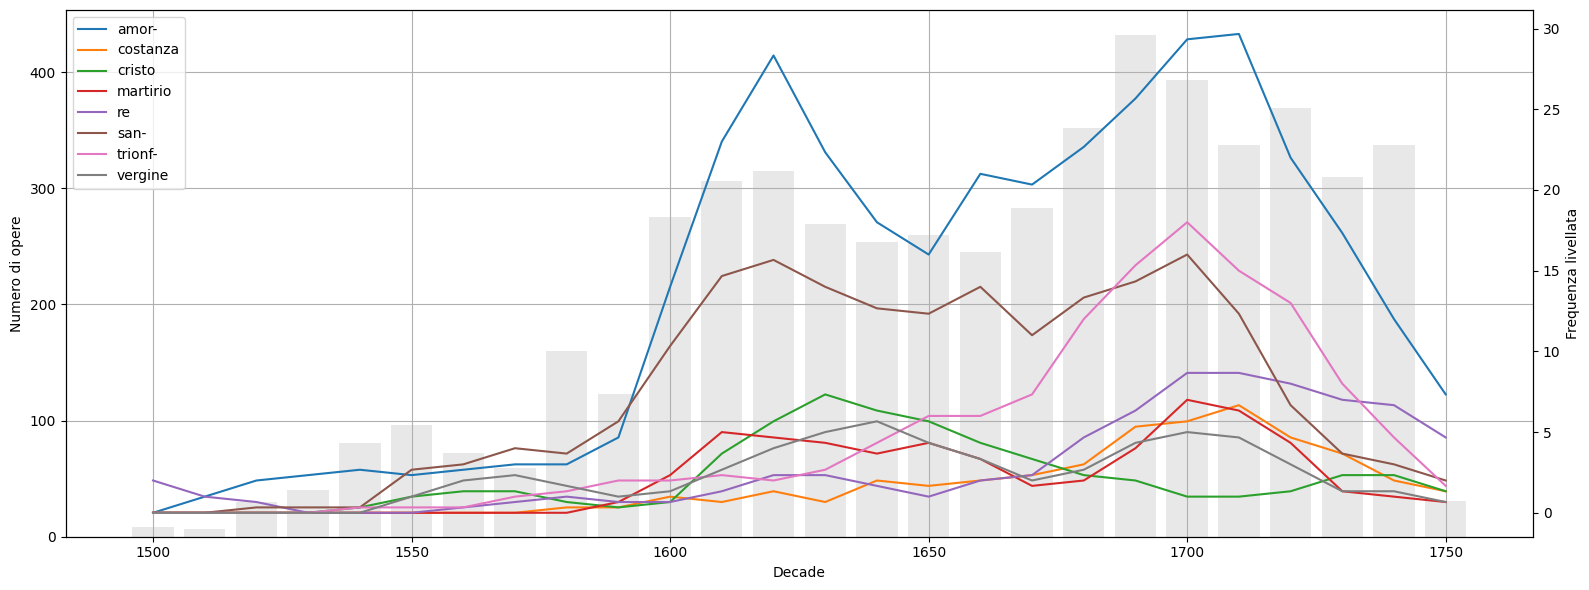

In [ ]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Define a dictionary to group words with different spellings
word_grouping = {
    'amore': 'amor-', 'amori': 'amor-', 'amor': 'amor-', 'amoroso': 'amor-', 'amorosa': 'amor-',
    'san': 'san-', 'san-': 'san-', 'santa': 'san-',
    'trionfante': 'trionf-', 'trionfo': 'trionf-'
}

# Step 2: Split titles into words and replace them based on the dictionary
def replace_variants(word):
    return word_grouping.get(word, word)  # Replace word if in dictionary, otherwise keep it unchanged

# Explode the titles into individual words and apply the mapping
all_words = df['processed_title'].str.split().explode().apply(replace_variants)

# Count the word frequencies after applying the grouping
word_counts = Counter(all_words)

# Step 3: Filter for frequent words (appear more than 30 times)
frequent_words = {word for word, count in word_counts.items() if count > 30}

# Step 4: Modify to aggregate by decade
df['decade'] = (df['anno/year'] // 10) * 10

df = df[(df['anno/year'] >= 1500) & (df['anno/year'] <= 1750)].copy()

# Modify to aggregate by decade
df['decade'] = (df['anno/year'] // 10) * 10

# Explode titles and apply mapping as before
exploded_df = df[['decade', 'processed_title']].copy()
exploded_df['words'] = df['processed_title'].str.split().apply(lambda x: [replace_variants(w) for w in x])
exploded_df = exploded_df.explode('words')

# Filter for frequent words
filtered_df = exploded_df[exploded_df['words'].isin(frequent_words)]

# Count occurrences by decade and word
word_decade_counts = filtered_df.groupby(['decade', 'words']).size().unstack(fill_value=0)

# Apply a moving average smoothing technique
smoothed_word_decade_counts = word_decade_counts.rolling(window=3, min_periods=1).mean()

# Count total number of entries per decade for the secondary axis
entries_per_decade = df.groupby('decade').size()

# Step 7: Plotting with moving average smoothing
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plotting the number of entries as a bar graph
ax1.bar(entries_per_decade.index, entries_per_decade, color='lightgray', alpha=0.5, label='Number of Entries', width=8)

# Create a second y-axis for the smoothed frequencies
ax2 = ax1.twinx()

# Define list of words to exclude and top 10 words for the legend
noprint = ['l', 'dell']  # Replace with your words to exclude
top_10_words = smoothed_word_decade_counts.sum().nlargest(10).index

# Plotting smoothed word frequencies
for word in smoothed_word_decade_counts.columns:
    if word not in noprint and word in top_10_words:
        # Get the decade's data (decade and counts)
        decade = smoothed_word_decade_counts.index
        counts = smoothed_word_decade_counts[word]

        # Plot the smoothed line
        ax2.plot(decade, counts, marker='', label=word)

# Linear scale
ax2.set_yscale('linear')

# Add titles and labels
ax1.set_xlabel('Decade')
ax1.set_ylabel('Numero di opere', color='black')
ax2.set_ylabel('Frequenza livellata', color='black')
ax1.grid(True)

# Clean up the legend
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


Here's a network of the most frequently associated words.

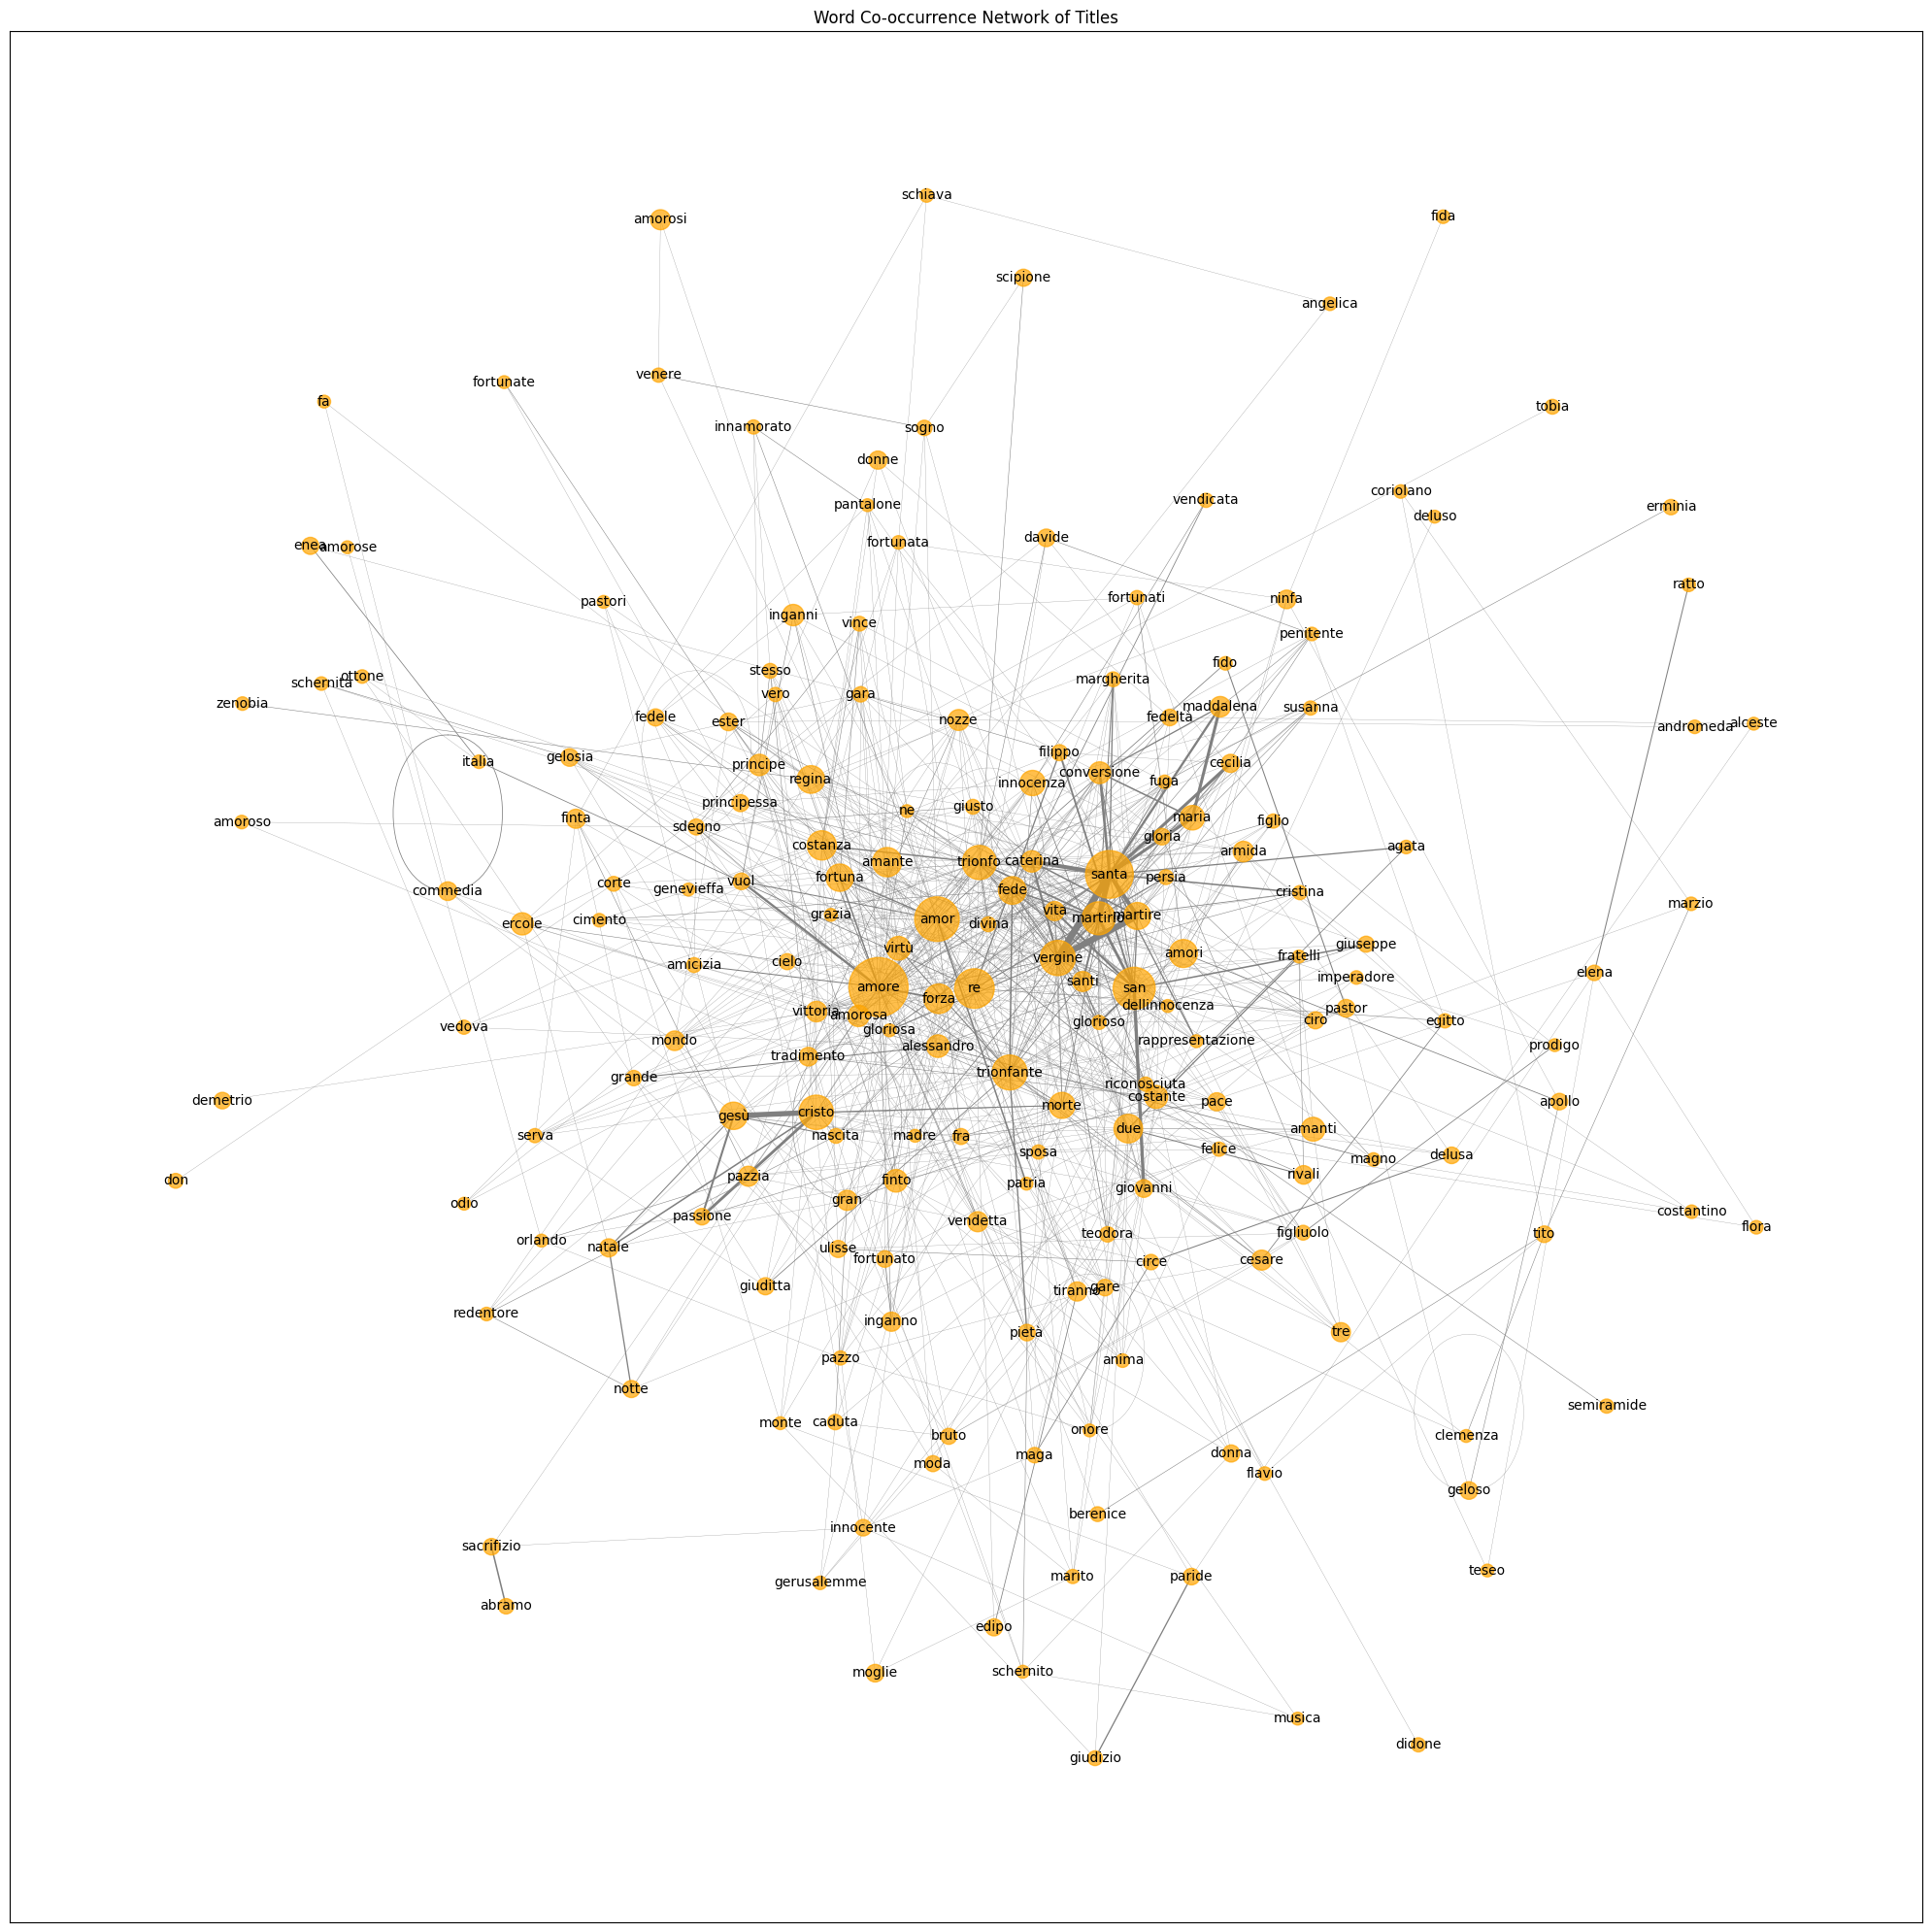

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

# Step 1: Count word frequencies
word_counter = Counter()
for title in processed_titles:
    words = title.split()
    word_counter.update(words)

# Step 2: Filter most frequent words
N = 200
most_common_words = set([word for word, count in word_counter.most_common(N)])

# Step 3: Build co-occurrence matrix
co_occurrence_counter = Counter()
for title in processed_titles:
    words = title.split()
    filtered_words = [word for word in words if word in most_common_words]
    co_occurrences = combinations(filtered_words, 2)
    co_occurrence_counter.update(co_occurrences)

# Step 4: Create the graph
G = nx.Graph()
for (word1, word2), count in co_occurrence_counter.items():
    if count >= 1:
        G.add_edge(word1, word2, weight=count)

# Prepare node frequencies
node_frequencies = {word: word_counter[word] for word in G.nodes()}

# Step 5: Visualize the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=[node_frequencies[node] * 10 for node in G.nodes()],
    node_color='orange',
    alpha=0.7
)

# Draw edges
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
normalized_widths = [weight / max(edge_weights) * 5 for weight in edge_weights]
nx.draw_networkx_edges(G, pos, edge_color='grey', width=normalized_widths)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Word Co-occurrence Network of Titles")
plt.tight_layout()
plt.show()


### Focus on person names

In [ ]:
# let's build a dictionary of recurrent person names
dict_person_names = {}
false_friends = ["amor","amoroso","amorosa"]
for word, count in sorted_word_counts.items():
  if word in ["gesù", "cristo"]:
    dict_person_names[word] = count
  elif word.lower() in italian_names:
    if word.lower() not in italian_words:
      if word not in false_friends:
        dict_person_names[word] = count

dict_person_names

In [ ]:
# Function to extract names from titles
def extract_names_from_title(title):
    words = title.lower().split()  # Split the title into words (lowercase for matching)
    names = []

    # Check each word in the title to see if it's a valid name (based on the criteria)
    for word in words:
        if word == "gesù" or word == "cristo" or word =="maria":
            names.append(word.capitalize())
        elif word in italian_names and word not in italian_words and word not in false_friends:
            names.append(word.capitalize())  # Add the name with capitalized first letter

    return ', '.join(names) if names else None  # Return all names as a comma-separated string

# Apply the function to extract the names and create a new 'names' column
df['names'] = df['processed_title'].apply(extract_names_from_title)

In [ ]:
df["names"].value_counts()

In [ ]:
def explore_names_by_genre(df):
    # Filter for commedia, tragedia, and dramma genres
    filtered_df = df[df['genere/genre'].isin(['commedia', 'tragedia', 'dramma'])]

    # Count the occurrences of each name per genre
    name_genre_counts = filtered_df.groupby(['names', 'genere/genre']).size().reset_index(name='counts')

    # Find the top 10 most frequent names
    top_names = name_genre_counts.groupby('names')['counts'].sum().nlargest(10).index
    additional_names = ['Gesù', 'Maria', 'Cristo']
    top_names = set(top_names).union(additional_names)

    # Filter the name_genre_counts for the top 10 names
    top_name_genre_counts = name_genre_counts[name_genre_counts['names'].isin(top_names)]

    # Print the associations for the top 10 most frequent names
    for name in top_names:
        print(f"Name: {name}")
        print(top_name_genre_counts[top_name_genre_counts['names'] == name][['genere/genre', 'counts']])
        print()

# Call the function
explore_names_by_genre(df)


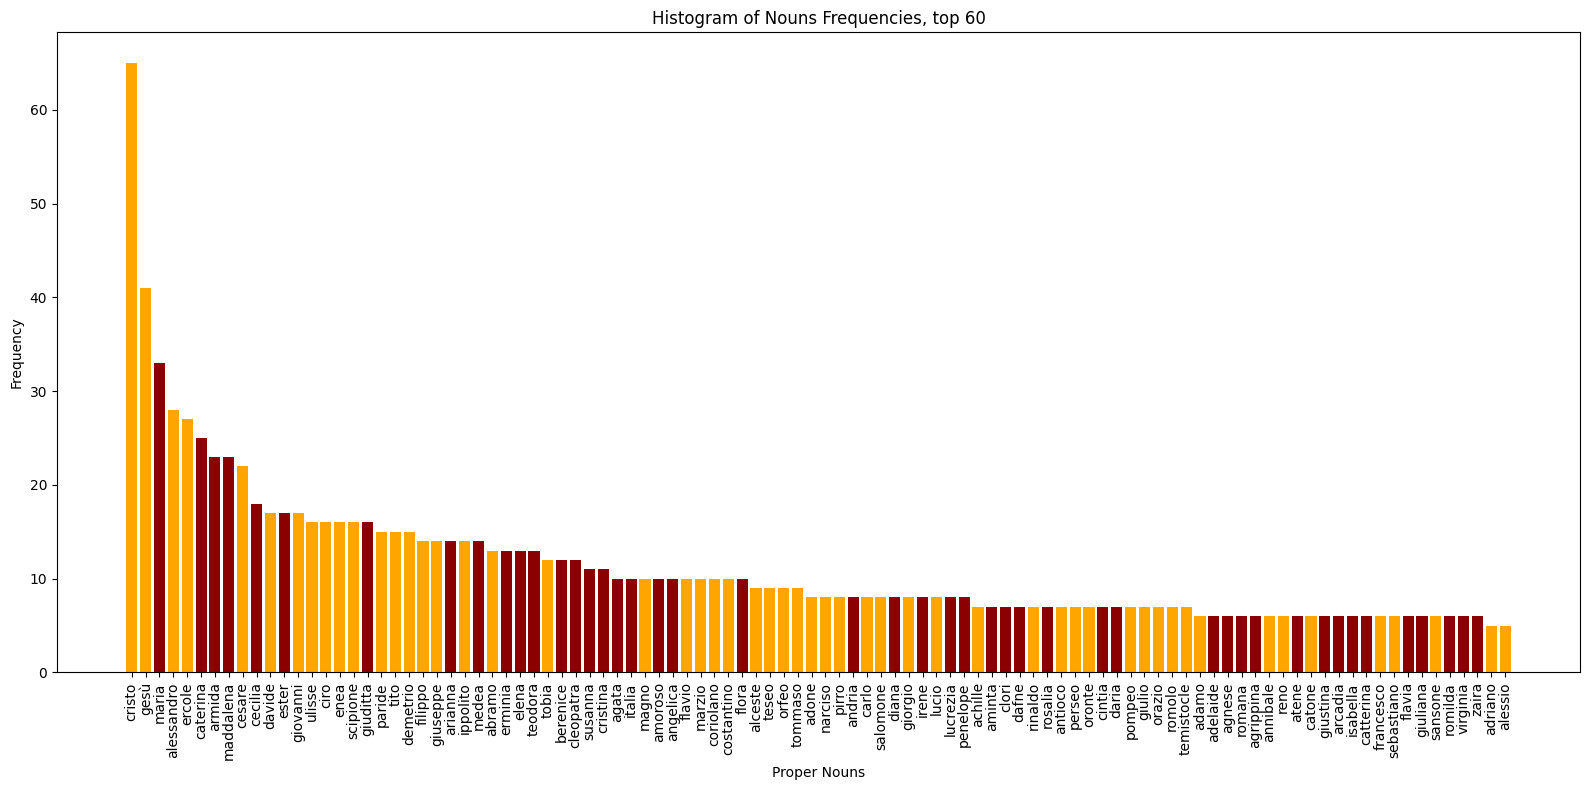

In [ ]:
# Initialize the gender detector
d = gender.Detector()

# Determine gender for each capitalized name
false_positives = ["gesù","enea","tobia","salomone","alceste","teseo","perseo","oronte","sansone"]
colors = ['orange' if d.get_gender(name.capitalize()) in ['male', 'mostly_male'] or name in false_positives else 'darkred' for name in dict_person_names.keys()]

# Plot with gender-based colors
plt.figure(figsize=(16, 8))
bars = plt.bar(list(dict_person_names.keys())[:100], list(dict_person_names.values())[:100], color=colors[:100])

# Add count on top of each bar
#for bar, count in zip(bars, list(dict_person_names.values())[:100]):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Proper Nouns')
plt.ylabel('Frequency')
plt.title('Histogram of Nouns Frequencies, top 60')
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# thanks to gpt + manual correction we categorised the names according to their origin
# we also removed some geographic names which slipped in

classical_names = [
    'ercole', 'cesare', 'ulisse', 'enea', 'scipione', 'paride', 'tito',
    'demetrio', 'ippolito', 'medea', 'berenice', 'cleopatra', 'flora',
    'alceste', 'teseo', 'orfeo', 'adone', 'narciso', 'pirro', 'diana',
    'lucio', 'lucrezia', 'penelope', 'achille', 'clori', 'dafne', 'perseo',
    'cintia', 'pompeo', 'orazio', 'temistocle', 'agrippina', 'annibale',
    'catone', 'flavia', 'zaira', 'ciro', 'antonio',
    'marzio', 'coriolano', 'andria', 'antioco', 'oronte',
    'arianna', 'romolo', 'costantino', 'aminta', 'flavio','amarilli','lidia'
]

modern_names = [
    'armida', 'erminia', 'romilda', 'rinaldo'
]

biblical_names = [
    'cristo', 'gesù', 'davide', 'ester', 'giovanni', 'abramo', 'tobia',
    'susanna', 'salomone', 'adamo', 'sansone', 'giuditta', 'maria', 'maddalena'
]

christian_names = [
    'alessandro', 'caterina', 'cecilia', 'eustachio',
    'filippo', 'giuseppe',  'elena', 'teodora', 'cristina', 'agata',
    'angelica', 'tommaso', 'carlo', 'giorgio', 'irene',  'rosalia',
    'daria', 'giulio',  'adelaide', 'agnese', 'giustina', 'isabella',
    'catterina', 'francesco', 'sebastiano', 'giuliana', 'virginia', 'adriano',
    'alessio'
]

In [ ]:
dict_person_names.keys()

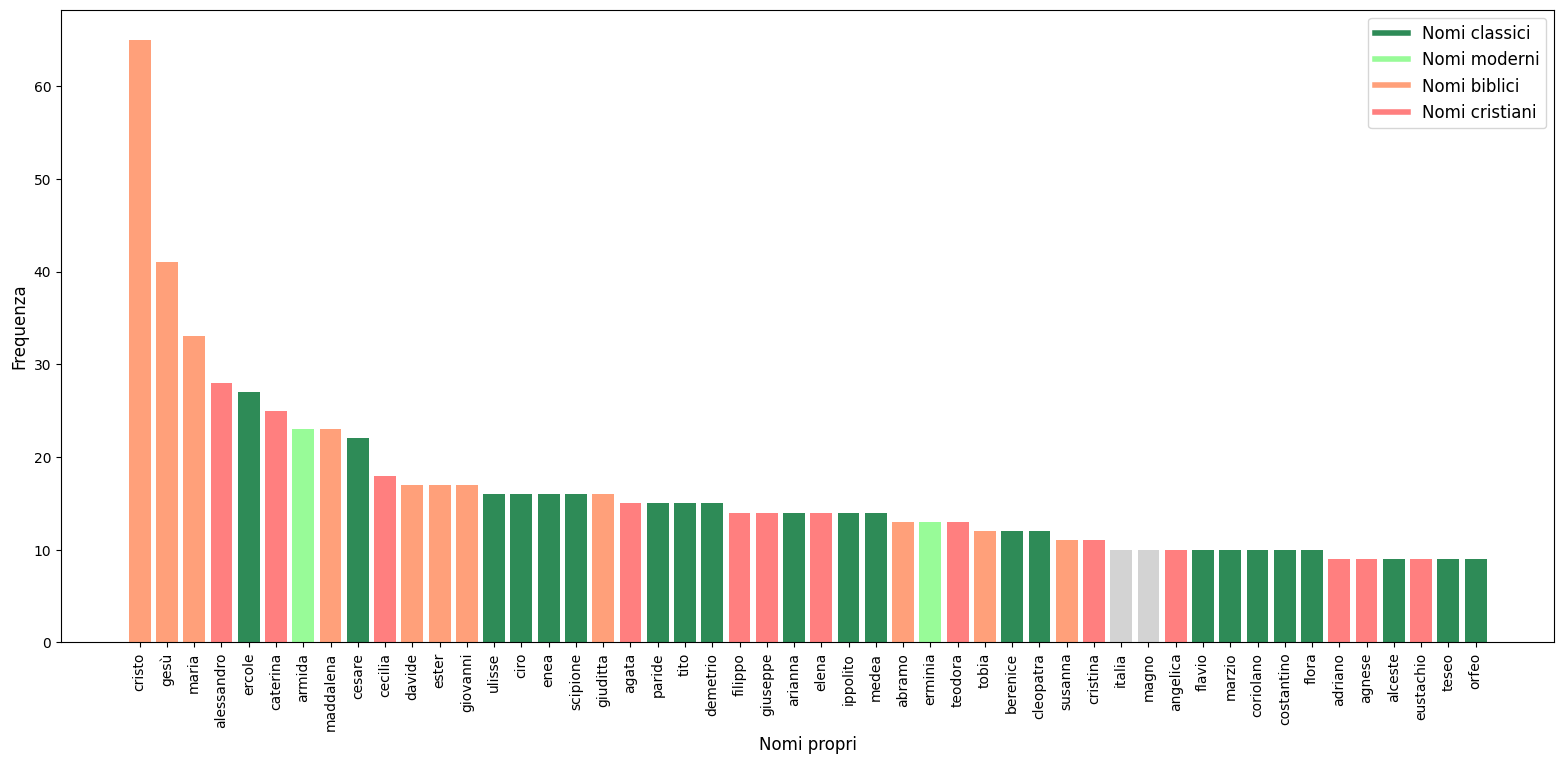

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Determine origin for each capitalized name and assign colors
colors = [
    '#2E8B57' if name in classical_names else
    '#98FB98' if name in modern_names else
    '#FFA07A' if name in biblical_names else
    '#FF7F7F' if name in christian_names else
    '#D3D3D3'
    for name in dict_person_names.keys()
]

# Adjust figure size to make the plot more compact
plt.figure(figsize=(16, 8))

# Plot with category-based colors
bars = plt.bar(list(dict_person_names.keys())[:50], list(dict_person_names.values())[:50], color=colors[:50])

# Add legend manually for all four categories
legend_elements = [
    Line2D([0], [0], color='#2E8B57', lw=4, label='Nomi classici'),
    Line2D([0], [0], color='#98FB98', lw=4, label='Nomi moderni'),
    Line2D([0], [0], color='#FFA07A', lw=4, label='Nomi biblici'),
    Line2D([0], [0], color='#FF7F7F', lw=4, label='Nomi cristiani')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Labels and final formatting
plt.xlabel('Nomi propri', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
#plt.title('Istogramma dei 50 nomi propri', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout(pad=2)

# Display the plot
plt.show()


In [ ]:
def filter_names(title, valid_names):
    return ' '.join([word for word in title.split() if word in valid_names])

# Apply the filter to the 'preprocessed_title' column
test_df['processed_title'] = test_df['processed_title'].apply(lambda x: filter_names(x, dict_person_names.keys()))
test_df.head()

In [ ]:
count_zero_years = (test_df["anno/year"] == 0).sum()
count_zero_years

437

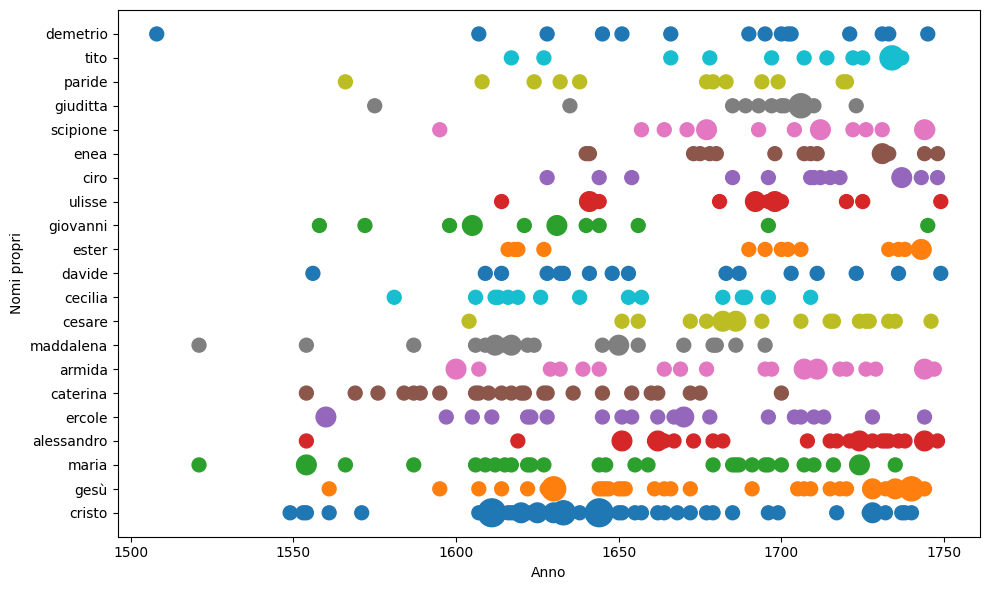

In [ ]:
def plot_name_occurrences(df, names_to_plot):
    # Remove entries where 'anno/year' is 0
    filtered_df = df[df['anno/year'] != 0]

    plt.figure(figsize=(10, 6))

    # Loop through the list of names and plot each
    for name in names_to_plot:
        # Filter rows where the name is present in the processed title
        name_df = filtered_df[filtered_df['processed_title'].str.contains(rf'\b{name}\b', regex=True, case=False)]

        # Count occurrences per year
        year_counts = name_df.groupby('anno/year').size().reset_index(name='counts')

        # Plot the occurrences, using 'counts' to determine the size of the points
        plt.scatter(year_counts['anno/year'], [name] * len(year_counts),
                    s=year_counts['counts'] * 100, label=name)

    # Plot formatting
    #plt.title(f"Occurrences of Names Over Time")
    plt.xlabel('Anno')
    plt.ylabel('Nomi propri')

    # Move the legend out of the plot area
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

# Example usage: plotting multiple names
d = ['cristo', 'gesù', 'maria', 'alessandro', 'ercole',
     'caterina', 'armida', 'maddalena', 'cesare', 'cecilia',
     'davide',  'ester', 'giovanni', 'ulisse', 'ciro', 'enea',
     'scipione', 'giuditta', 'paride', 'tito', 'demetrio']
plot_name_occurrences(df, d)

In [ ]:
print(df[df['processed_title'].str.contains(r'\btito\b', regex=True, case=False)])

                                             voce/entry  \
1250  CLEMENZA DI TITO. Dramma rappresentato nella C...   
1414  CORIOLANO TITO MARZIO. Tragedia (in versi scio...   
2624  GIUDEA DISTRUTTA DA VESPASIANO E TITO. Tragedi...   
4824  TITO. Dramma recitato nel Teatro de' SS. Gio. ...   
4825  TITO CONVERTITO. Rappresentazione Spirituale. ...   
4826  TITO, E BERENICE. Dramma per Musica rappresent...   
4827  TITO MANLIO. Dramma recitato nel Teatro di S. ...   
4828  TITO MANLIO. Tragedia (in prosa). — in Bologna...   
4829  TITO SEMPRONIO GRACCO. Dramma per Musica recit...   
5087  VESPASIANO, TITO FLAVIO. Azione Accademica rap...   
5106  VINCITOR MAGNANIMO IN TITO QUINTO FLAMINIO. Dr...   
5407  CLEMENZA DI TITO. Dramma. — in Venezia, per il...   
5992  TITO, E BERENICE. Tragedia di Pietro Cornelio ...   
5994  TITO MANLIO. Tragedia. — in Venezia, per Tomma...   
5995  TITO MARZIO CORIOLANO. Tragedia. — in Bologna,...   

                                    titolo/title sottot

Trying to check recurrent POS constellations (but directly on preprocessed titles due to poor performance)

In [ ]:
# Load the Italian model for Stanza (SpaCy works even worse)
nlp = stanza.Pipeline('it', processors='tokenize,pos', tokenize_pretokenized=False)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

In [ ]:
# Counter for storing pattern frequency
from collections import Counter
pattern_counter = Counter()
example_titles = {}

# Process each title in the DataFrame
for title in df["processed_title"]:
    doc = nlp(title)
    pattern = []  # To store the POS pattern for the current title

    for sentence in doc.sentences:
        for word in sentence.words:
            pattern.append(word.upos)  # Collect the Universal POS tag (e.g., NOUN, VERB)

    # Join POS tags to form the syntactic pattern string
    pattern_str = '+'.join(pattern)

    # Increment pattern frequency and save example title if it's the first occurrence
    pattern_counter[pattern_str] += 1
    if pattern_str not in example_titles:
        example_titles[pattern_str] = title  # Store the first title with this pattern

# Sort patterns by frequency
sorted_patterns = pattern_counter.most_common()

# Output the patterns with frequency and example titles
for pattern, freq in sorted_patterns:
    print(f"{pattern}: {freq} times - example title: {example_titles[pattern]}")


In [ ]:
# prompt: print the average lenght of titles of "commedia", "tragedia", and "dramma" for each 20 years span between 1500 to 1750

# Assuming 'test_df' is your DataFrame and it has columns 'genere/genre', 'anno/year', and 'title_length'.

def average_title_length_by_genre_and_period(df, genres, start_year, end_year, period_length):
    """Calculates the average title length for specified genres within time periods."""
    results = {}
    for genre in genres:
        genre_df = df[(df['genere/genre'] == genre)]
        for year in range(start_year, end_year + 1, period_length):
            period_end = min(year + period_length -1, end_year)
            period_df = genre_df[(genre_df['anno/year'] >= year) & (genre_df['anno/year'] <= period_end)]

            if not period_df.empty:
                avg_length = period_df['title_length'].mean()
                results.setdefault(genre, {})[f"{year}-{period_end}"] = avg_length
            else:
                 results.setdefault(genre, {})[f"{year}-{period_end}"] = 0 # or handle as needed

    return results

# Example usage
genres_to_analyze = ["commedia", "tragedia", "dramma"]
start_year = 1500
end_year = 1750
period_length = 20

average_lengths = average_title_length_by_genre_and_period(test_df, genres_to_analyze, start_year, end_year, period_length)


# Print the results
for genre, periods in average_lengths.items():
    print(f"Average title lengths for {genre}:")
    for period, avg_length in periods.items():
        print(f"  {period}: {avg_length:.2f}")

Average title lengths for commedia:
  1500-1519: 1.00
  1520-1539: 1.21
  1540-1559: 1.14
  1560-1579: 1.36
  1580-1599: 1.35
  1600-1619: 1.60
  1620-1639: 1.84
  1640-1659: 1.80
  1660-1679: 2.18
  1680-1699: 1.97
  1700-1719: 2.00
  1720-1739: 1.87
  1740-1750: 1.57
Average title lengths for tragedia:
  1500-1519: 3.33
  1520-1539: 1.78
  1540-1559: 1.19
  1560-1579: 1.17
  1580-1599: 1.27
  1600-1619: 1.52
  1620-1639: 1.55
  1640-1659: 1.73
  1660-1679: 2.05
  1680-1699: 2.35
  1700-1719: 1.54
  1720-1739: 1.41
  1740-1750: 1.45
Average title lengths for dramma:
  1500-1519: 0.00
  1520-1539: 0.00
  1540-1559: 0.00
  1560-1579: 1.67
  1580-1599: 2.00
  1600-1619: 2.13
  1620-1639: 2.61
  1640-1659: 1.67
  1660-1679: 1.83
  1680-1699: 2.02
  1700-1719: 2.08
  1720-1739: 1.77
  1740-1750: 1.72


Topic modelling

In [ ]:
# Apply preprocessing to titles
new_df = df['titolo/title'].apply(preprocess_text)

# Prepare the data for topic modeling
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='italian')
dtm = vectorizer.fit_transform(new_df.fillna(''))

# Perform topic modeling using LDA
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic #{topic_idx + 1}: {' '.join(top_words)}")



Topic #1: amanti amore vittoria ninfa inganno ester giuditta fedeltà arianna regina
Topic #2: martirio inganni vendetta amore ifigenia edipo ciro principessa persia notte
Topic #3: amori armida pazzia moglie ippolito cielo pastor sogno berenice semiramide
Topic #4: fede alessandro ercole cesare san giovanni amorosa egitto grande amante
Topic #5: finta tre medea bruto gelosia santi giusto susanna felice angelica
Topic #6: forza vergine martire costante tradimento principe gare innamorato ulisse sofonisba
Topic #7: trionfo nozze commedia regina demetrio donna corte delusa fedele donne
Topic #8: amore amor cristo gesù costanza fortuna innocenza finto trionfo natale
Topic #9: mondo geloso sdegno elena gloria zenobia figliuolo orlando schernito conversione
Topic #10: santa san trionfante martirio amante caterina maddalena maria conversione cecilia


In [ ]:
# prompt: Avec le DataFrame titles_df: topic model the column processed title

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')  # Adjust parameters as needed
dtm = vectorizer.fit_transform(titles_df['processed_title'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42) # Adjust number of topics (n_components)
lda.fit(dtm)

# Get top words for each topic
for index, topic in enumerate(lda.components_):
    print(f"Top words for topic {index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])  # Print top 10 words
    print()

# Transform the document-term matrix into topic probabilities
topic_results = lda.transform(dtm)

# Add topic probabilities to the DataFrame
for i in range(lda.n_components):
  titles_df[f'topic_{i}'] = topic_results[:,i]

Top words for topic 0:
['andromaca', 'didone', 'giusto', 'fedele', 'passione', 'notte', 'santi', 'natale', 'gesù', 'cristo']

Top words for topic 1:
['coriolano', 'fortunato', 'fede', 'sdegno', 'vince', 'giudizio', 'finta', 'fra', 'paride', 'amor']

Top words for topic 2:
['ottone', 'flora', 'tito', 'principessa', 'geloso', 'pace', 'commedia', 'inganno', 'fortuna', 'amante']

Top words for topic 3:
['cecilia', 'vergine', 'maddalena', 'trionfo', 'costanza', 'maria', 'amori', 'martirio', 'forza', 'santa']

Top words for topic 4:
['teodora', 'demetrio', 'vuol', 'martire', 'amorosi', 'alessandro', 'regina', 'vergine', 'trionfante', 'amore']

Top words for topic 5:
['giuseppe', 'arianna', 'medea', 'innocente', 'sacrifizio', 'donne', 'giovanni', 'vita', 'fede', 'san']

Top words for topic 6:
['ifigenia', 'erminia', 'moglie', 'ester', 'armida', 'ninfa', 'pazzia', 'cesare', 'costante', 'amanti']

Top words for topic 7:
['merope', 'endimione', 'magno', 'gara', 'egitto', 'gelosia', 'pastor', 'ti

<ipython-input-16-339e608d6e00>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles_df[f'topic_{i}'] = topic_results[:,i]
<ipython-input-16-339e608d6e00>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles_df[f'topic_{i}'] = topic_results[:,i]
<ipython-input-16-339e608d6e00>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Trashbin/drafts

In [ ]:
df.columns

Index(['', 'voce/entry', 'titolo/title', 'sottitolo/subtitle', 'autore/author',
       'ids_authors', 'genere/genre', 'metro/mode',
       'luogo di pubblicazione/city', 'ids_city',
       'luogo di rappresentazione/location', 'ids_location',
       'editore/publisher', 'ids_publisher', 'anno/year', 'formato/format',
       'libretto', 'compositore/composer', 'ids_composer',
       'traduzione/translation', 'author_link'],
      dtype='object')

In [ ]:
# URL of the CSV file
url = 'https://github.com/allacci-digitale/allacci-digitale.github.io/raw/main/data/refined-database.json.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(url)
df.columns = df.columns.str.replace('_ - ', '', regex=False)

cols = ['ids_authors', 'ids_city', 'ids_location', 'ids_publisher', 'ids_composer']
for col in cols:
    df[col].fillna('x', inplace=True)

# Function to create the HTML anchor tag
def create_anchor_tag(column, id):
    if id != 'x':
      return f'<a href="https://www.wikidata.org/wiki/{id}">{column}</a>'
    else:
      return column

# Apply the function to create a new column

df['author_link'] = df.apply(lambda row: create_anchor_tag(row['autore/author'], row['ids_authors']), axis=1)
df['city_link'] = df.apply(lambda row: create_anchor_tag(row['luogo di pubblicazione/city'], row['ids_city']), axis=1)
df['location_link'] = df.apply(lambda row: create_anchor_tag(row['luogo di rappresentazione/location'], row['ids_location']), axis=1)
df['publisher_link'] = df.apply(lambda row: create_anchor_tag(row['editore/publisher'], row['ids_publisher']), axis=1)
df['composer_link'] = df.apply(lambda row: create_anchor_tag(row['compositore/composer'], row['ids_composer']), axis=1)

#Drop the original 'author' and 'author:ids' columns
df = df.drop(columns=['autore/author', 'ids_authors',
       'luogo di pubblicazione/city', 'ids_city',
       'luogo di rappresentazione/location', 'ids_location',
       'editore/publisher', 'ids_publisher',
       'compositore/composer', 'ids_composer'])

# Rearrange columns
new_column_order = ['voce/entry', 'titolo/title', 'sottitolo/subtitle','author_link',
                    'genere/genre', 'metro/mode','city_link', 'location_link',
                    'publisher_link', 'anno/year', 'formato/format', 'libretto',
                    'composer_link', 'traduzione/translation']

df = df[new_column_order]


# Define the renaming dictionary for specific columns
renaming_dict = {'author_link': 'autore/author', 'city_link': 'luogo di pubblicazione/city',
       'location_link': 'luogo di rappresentazione/location', 'publisher_link': 'editore/publisher',
       'composer_link': 'compositore/composer'}

# Rename specific columns using the dictionary
df.rename(columns=renaming_dict, inplace=True)

# Display the modified DataFrame
df

# Optionally, save the modified DataFrame to a new CSV file
df.to_csv('database.csv', index=False)


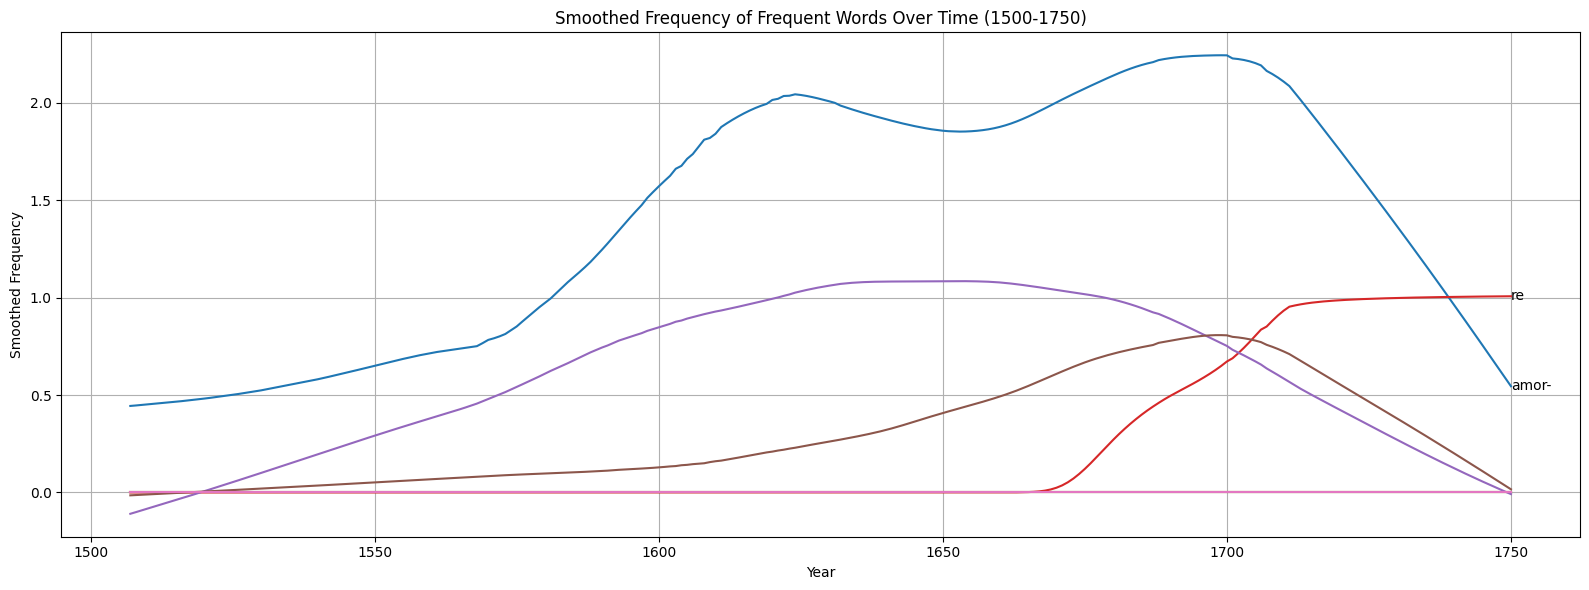

In [ ]:

# Step 4: Filter for the timeframe 1500-1750
time_filtered_df = test_df[(test_df['anno/year'] >= 1500) & (test_df['anno/year'] <= 1750)]

# Explode the titles into individual words with their respective years and apply the mapping
exploded_df = time_filtered_df[['anno/year', 'processed_title']].copy()
exploded_df['words'] = time_filtered_df['processed_title'].str.split().apply(lambda x: [replace_variants(w) for w in x])
exploded_df = exploded_df.explode('words')

# Filter only rows containing frequent words
filtered_df = exploded_df[exploded_df['words'].isin(frequent_words)]

# Step 5: Now, group by year and word to count occurrences
word_yearly_counts = filtered_df.groupby(['anno/year', 'words']).size().unstack(fill_value=0)

# Step 6: Filter to remove near-zero frequencies (adjusted threshold)
min_freq_threshold = 1  # Set a lower minimum threshold for filtering
filtered_word_yearly_counts = word_yearly_counts.loc[:, (word_yearly_counts > min_freq_threshold).any()]

# Step 7: Plotting with LOWESS smoothing
plt.figure(figsize=(16, 6))

for word in filtered_word_yearly_counts.columns:
    # Get the word's data (year and counts)
    year = filtered_word_yearly_counts.index
    counts = filtered_word_yearly_counts[word]

    # Apply LOWESS smoothing
    smoothed = sm.nonparametric.lowess(counts, year, frac=0.4)  # Adjust frac for better smoothing

    # Plot the smoothed line
    plt.plot(smoothed[:, 0], smoothed[:, 1], marker='', label=word)

    # Label words at the end of their line if the final value is significant
    if smoothed[-1, 1] > 0.05:  # You can lower this threshold if necessary
        plt.text(smoothed[-1, 0], smoothed[-1, 1], word, fontsize=10, ha='left', va='center')

# Linear scale (no log scale)
plt.yscale('linear')

# Add titles and labels
plt.title('Smoothed Frequency of Frequent Words Over Time (1500-1750)')
plt.xlabel('Year')
plt.ylabel('Smoothed Frequency')
plt.grid(True)

# Remove legend for cleaner look
#plt.legend().remove()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Step 4: Modify to aggregate by decade
time_filtered_df['decade'] = (time_filtered_df['anno/year'] // 10) * 10

# Explode titles and apply mapping as before
exploded_df = time_filtered_df[['decade', 'processed_title']].copy()
exploded_df['words'] = time_filtered_df['processed_title'].str.split().apply(lambda x: [replace_variants(w) for w in x])
exploded_df = exploded_df.explode('words')

# Filter for frequent words
filtered_df = exploded_df[exploded_df['words'].isin(frequent_words)]

# Count occurrences by decade and word
word_decade_counts = filtered_df.groupby(['decade', 'words']).size().unstack(fill_value=0)

# Apply a moving average smoothing technique
smoothed_word_decade_counts = word_decade_counts.rolling(window=3, min_periods=1).mean()

# Step 7: Plotting with moving average smoothing
plt.figure(figsize=(20, 40))

for i, word in enumerate(smoothed_word_decade_counts.columns):
    # Get the decade's data (decade and counts)
    decade = smoothed_word_decade_counts.index
    counts = smoothed_word_decade_counts[word]

    # Plot the smoothed line
    plt.plot(decade, counts, marker='', label=word)

    # Get the last position for the label
    last_decade = decade[-1]
    last_count = counts.iloc[-1]

    # Determine label position
    if i % 2 == 0:  # Alternate labels
        plt.text(last_decade, last_count + 0.02, word, fontsize=10, ha='left', va='center')
    else:
        plt.text(last_decade, last_count - 0.02, word, fontsize=10, ha='right', va='center')

    # Draw a line connecting the label to the end of the curve
    plt.plot([last_decade, last_decade], [last_count, last_count + (0.02 if i % 2 == 0 else -0.02)], 'k--', lw=0.5)

# Linear scale
plt.yscale('linear')

# Add titles and labels
plt.title('Smoothed Frequency of Frequent Words Over Time (1500-1750)')
plt.xlabel('Decade')
plt.ylabel('Smoothed Frequency')
plt.grid(True)

# Clean up the legend
plt.legend().remove()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Step 4: Modify to aggregate by decade
time_filtered_df['decade'] = (time_filtered_df['anno/year'] // 10) * 10

# Explode titles and apply mapping as before
exploded_df = time_filtered_df[['decade', 'processed_title']].copy()
exploded_df['words'] = time_filtered_df['processed_title'].str.split().apply(lambda x: [replace_variants(w) for w in x])
exploded_df = exploded_df.explode('words')

# Filter for frequent words
filtered_df = exploded_df[exploded_df['words'].isin(frequent_words)]

# Count occurrences by decade and word
word_decade_counts = filtered_df.groupby(['decade', 'words']).size().unstack(fill_value=0)

# Apply a moving average smoothing technique
smoothed_word_decade_counts = word_decade_counts.rolling(window=3, min_periods=1).mean()

# Plotting with Plotly
fig = go.Figure()

# Line plots for each word's smoothed frequency
for word in smoothed_word_decade_counts.columns:
    fig.add_trace(
        go.Scatter(
            x=smoothed_word_decade_counts.index,
            y=smoothed_word_decade_counts[word],
            mode='lines+markers',
            name=word,  # Relying on the legend for labeling
            line=dict(width=2)
        )
    )

# Layout adjustments
fig.update_layout(
    title="Smoothed Frequency of Frequent Words Over Time (1500-1750)",
    xaxis_title="Decade",
    yaxis_title="Smoothed Frequency",
    legend=dict(title="Words", orientation="h", x=0, y=-0.2),
    template="plotly_white",
    height=600,
    width=1000
)

fig.show()


<ipython-input-16-54f7ca39d8a7>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

